# Duck Egg Quality Classification Based on its Shell Visual Property through Image Processing and Deep Learning


Group CGM: <br>

Caguioa, JV Bryan <br>
Guinto, Ryhle Nodnyhlson <br>
Mesias, Lee Reuben

# References

https://thedatafrog.com/en/articles/image-recognition-transfer-learning/ <br>
https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538 <br>
https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python <br>
https://keras.io/examples/vision/grad_cam/

## Imports

In [1]:
import os                                              # define and move to dataset and model directory
import shutil                                          # duplicate images and delete directories
import sys                                             # exit out code     
import cv2                                             

import tensorflow.keras as keras
import numpy as np
import tensorflow as tf                                 #for callbacks
import seaborn as sn
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt                         #histograph/confusion matrix

from sklearn.model_selection import StratifiedKFold     #k-fold cross validation
from sklearn.model_selection import train_test_split    #split the dataset to train-test

from tensorflow.keras.preprocessing.image import ImageDataGenerator      # data augmentation
from tensorflow.keras.preprocessing import image as im                   #load image
from tensorflow.keras.applications.resnet50 import preprocess_input      #preprocess image                                                               

#measure performance metrics
#---------------------------------------------------------------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc       
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import label_binarize

from scipy import interp                            #interpolation needed for plotting all classes into one roc plot
from itertools import cycle                         #for the color of lines on that multiclass plot
#---------------------------------------------------------------------------------------------------------------------

#Grad-CAM
from IPython.display import Image, display
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# the directory where the data is stored
directory = "C:/Users/user/Desktop/Dataset"
#directory where set of models per training are stored
gen_dir = "C:/Users/user/Desktop/Model"

if not os.path.exists(directory):
    os.makedirs(directory)
if not os.path.exists(gen_dir):
    os.makedirs(gen_dir)

## Put Dataset in a Dataframe

The directory of the images are put in a dataframe in order to prepare for splitting the dataset into train and test set.

In [3]:
totaldsdirect = directory + "/TotalCombined"

image = []

if not os.path.exists(totaldsdirect):
    print("Directory does not exist. Please run the code on data cleaning notebook.")
    sys.exit()

#label the images
for x in os.listdir(totaldsdirect):
    totaldsdirect2 = totaldsdirect + "/" + x
    for y in os.listdir(totaldsdirect2):
        if x == "Balut-penoy4":
            lbl = "0"
        elif x == "Salted egg4":
            lbl = "1"
        else:
            lbl = "2"
                 
        #append to image array
        image.append([totaldsdirect2 + "/" + y,lbl])

In [4]:
df = pd.DataFrame(image,columns=['filename','label'])
df

,filename,label
0,C:/Users/user/Desktop/Dataset/TotalCombined/Ba...,0
1,C:/Users/user/Desktop/Dataset/TotalCombined/Ba...,0
2,C:/Users/user/Desktop/Dataset/TotalCombined/Ba...,0
3,C:/Users/user/Desktop/Dataset/TotalCombined/Ba...,0
4,C:/Users/user/Desktop/Dataset/TotalCombined/Ba...,0
...,...,...
595,C:/Users/user/Desktop/Dataset/TotalCombined/Ta...,2
596,C:/Users/user/Desktop/Dataset/TotalCombined/Ta...,2
597,C:/Users/user/Desktop/Dataset/TotalCombined/Ta...,2
598,C:/Users/user/Desktop/Dataset/TotalCombined/Ta...,2


Classes: <br>
0 - Balut/Penoy <br> 
1 - Salted <br>
2 - Table

## Split Data to train and test set

We will need to split the dataset to train and test set (90:10). Only the train set will be used for Hyperparameter tuning with Stratified K-fold Cross Validation. Test set will be used for model prediction and model evaluation. Stratify is used in order to split the data in equal numbers under each class specified.

In [5]:
# Split the data to train and test
X = df[['filename']]
y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

Save the images in the split sets to train and test set folders.

In [6]:
#folder to store the train and test set folders
fortraintest = directory + "/ToBeUsed"
if not os.path.exists(fortraintest):
    os.makedirs(fortraintest)

#train set folder
tr = fortraintest + "/train_set"
if not os.path.exists(tr):
    os.makedirs(tr)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr)
    os.makedirs(tr)
    
#test set folder
te = fortraintest + "/test_set"
if not os.path.exists(te):
    os.makedirs(te)
else:
    #remove previous folder and create new one
    shutil.rmtree(te)
    os.makedirs(te)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    trcpy = shutil.copy2(row['filename'], tr)
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_test.iterrows():
    tecpy = shutil.copy2(row['filename'], te)
    X_test.loc[X_test['filename']==row['filename'],'filename']=tecpy #change to directory where image is copied

### Train Set

In [7]:
df2 = pd.concat([X_train,y_train],axis=1)
df2

,filename,label
11,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
581,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
377,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
487,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
216,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
...,...,...
273,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
486,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
86,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
200,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1


To check whether or not there are equal amounts of images per class in the train set, we have done what is shown below.

In [8]:
counto = [0,0,0]

counto_count = 0

df2_lbl = sorted(df2['label'].unique(), reverse=False) 

for x in df2_lbl:
    for y in df2['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1

In [9]:
print(counto)

[180, 180, 180]


### Test Set

In [10]:
df3 = pd.concat([X_test,y_test],axis=1)
df3

,filename,label
177,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0
535,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
563,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
498,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
502,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
257,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,1
559,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
134,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0
298,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,1
10,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0


Same with the train set, we checked whether or not there is an equal distribution of images in the test set.

In [11]:
counto = [0,0,0]

counto_count = 0

df3_lbl = sorted(df3['label'].unique(), reverse=False) 

for x in df3_lbl:
    for y in df3['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1

In [12]:
print(counto)

[20, 20, 20]


## Functions

### Create Plot History

Plot history will display the training and validation accuracy and loss in every epoch per fold.

In [13]:
def plot_history(history, yrange):
    #Plot loss and accuracy as a function of the epoch,
    #for the training and validation datasets.
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25
    
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train_loss','val_loss'])
    
    plt.show() 

### Save Models

Stratified K-fold Cross Validation will be used in getting the best hyperparameters that will be utilized to train the final model. The set of model weights produced per fold will be saved in an automatic generated folder. Every training will generate another folder to save the new set.

In [14]:
def savemodel():
    save_cur = ""  #check if there is any saved_models folder(s)

    svnum = 0
    svnum2 = 0

    for x in os.listdir(gen_dir):
        if "saved_models" in x:
            save_cur = x
            if not save_cur == "":
                for word in save_cur.split("_"):
                    if word.isdigit():
                        svnum2 = int(word)
                        if svnum < svnum2:
                            svnum = svnum2


    #save_dir is where the created models using the current set of hyperparameters are added        
    if save_cur == "":
        save_dir = gen_dir + "/saved_models_1"
        os.makedirs(save_dir)
    else:
        save_dir = gen_dir + "/saved_models_" + str(svnum + 1)
        os.makedirs(save_dir)
        
    return save_dir

## Data Augmentation

We will apply data augmentation to increase the dataset. We will use data augmentation per epoch in order to generate unique images in order to increase the dataset.

In [15]:
resnet50 = keras.applications.resnet50

imgdatagen = ImageDataGenerator(
        preprocessing_function = resnet50.preprocess_input,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = 10,
        height_shift_range = 10,
        rotation_range = 5,
        brightness_range = [0.8,1.3],
        fill_mode = "nearest"
    )

## Model Creation

The model will be based on ResNet50 Architecture. The classifier block will be changed to suit to our dataset.

In [16]:
def create_model():
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in conv_model.layers:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(3, activation='softmax')(x)

    full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

    return full_model

In [17]:
full_model = create_model()
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Hyperparameter Tuning

We will check the combination of hyperparameters that yielded the highest validation accuracy and lowest validation loss. A set of values on chosen hyperparameters is given. The best combination will be used to train the final model.

### Model Hyperparameters

In [18]:
batch_size_arr = [8]                                #batch size
num_epochs_arr = [200]                              #number of epochs
lr_arr = [0.0001]                                   #learning rate Adamax

### Initialize Variables

In [19]:
VALIDATION_ACCURACY = []                          #holds all validation_accuracy in current combination
VALIDATION_LOSS = []                              #holds all validation_loss in current combination

TRAIN_ACCURACY = []                               #holds all train_accuracy in current combination
TRAIN_LOSS = []                                   #holds all train_loss in current combination

param_arr = []                                    #holds the hyperparameter values per combination

val_acc_arr = []                                  #holds the set of validation accuracy per combination
val_loss_arr = []                                 #holds the set of validation loss per combination
val_acc_means = []                                #holds the means of all set of validation accuracy per combination
val_loss_means = []                               #holds the means of all set of validation loss per combination

train_acc_arr = []                                #holds the set of train accuracy per combination
train_loss_arr = []                               #holds the set of train loss per combination
train_acc_means = []                              #holds the means of all set of train accuracy per combination
train_loss_means = []                             #holds the means of all set of train loss per combination

### Train, Validation, Test data settings

In [20]:
train_dir = directory + "/ToBeUsed/train_set"     #where the train set images are stored

#strat kfold parameters
Y = df2[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 69, shuffle = True)

#to get the test set images convert the image to numpy array and store to testX
testX = []

for img_path in X_test['filename']:
    img = im.load_img(img_path, target_size=(224,224))
    x = im.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = x.reshape(224,224,3)
    testX.append(x)

testX = np.array(testX)

yt = pd.to_numeric(y_test['label'])                #make the labels to integer to get the model metrics

Train the model per combination of hyperparameters.


batch size:  8
epochs:  200
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/200
54/54 [==============================] - 17s 210ms/step - loss: 1.1726 - accuracy: 0.4792 - val_loss: 1.0067 - val_accuracy: 0.5278

Epoch 00001: val_accuracy improved from -inf to 0.52778, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 2/200
54/54 [==============================] - 8s 148ms/step - loss: 0.8856 - accuracy: 0.6088 - val_loss: 0.9404 - val_accuracy: 0.5648

Epoch 00002: val_accuracy improved from 0.52778 to 0.56481, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 3/200
54/54 [==============================] - 8s 149ms/step - loss: 0.8102 - accuracy: 0.6319 - val_loss: 0.8553 - val_accuracy: 0.6481

Epoch 00003: val_accuracy improved from 0.56481 to 0.64815, saving model to C:/Users/user/Desktop/Model/saved_models_1\mod

54/54 [==============================] - 9s 172ms/step - loss: 0.4783 - accuracy: 0.8148 - val_loss: 0.4215 - val_accuracy: 0.8241

Epoch 00038: val_accuracy improved from 0.81481 to 0.82407, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 39/200
54/54 [==============================] - 10s 179ms/step - loss: 0.3712 - accuracy: 0.8657 - val_loss: 0.3980 - val_accuracy: 0.8333

Epoch 00039: val_accuracy improved from 0.82407 to 0.83333, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 40/200
54/54 [==============================] - 8s 153ms/step - loss: 0.4386 - accuracy: 0.8218 - val_loss: 0.4379 - val_accuracy: 0.8426

Epoch 00040: val_accuracy improved from 0.83333 to 0.84259, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 41/200
54/54 [==============================] - 9s 166ms/step - loss: 0.4165 - accuracy: 0.8380 - val_loss: 0.6011 - val_accuracy: 0.7685

Epoch 00041: val_accuracy did not improve 

54/54 [==============================] - 10s 177ms/step - loss: 0.3539 - accuracy: 0.8681 - val_loss: 0.3964 - val_accuracy: 0.8333

Epoch 00077: val_accuracy did not improve from 0.88889
Epoch 78/200
54/54 [==============================] - 9s 168ms/step - loss: 0.3527 - accuracy: 0.8657 - val_loss: 0.3091 - val_accuracy: 0.8704

Epoch 00078: val_accuracy did not improve from 0.88889
Epoch 79/200
54/54 [==============================] - 9s 164ms/step - loss: 0.2774 - accuracy: 0.8819 - val_loss: 0.3079 - val_accuracy: 0.8611

Epoch 00079: val_accuracy did not improve from 0.88889
Epoch 80/200
54/54 [==============================] - 10s 179ms/step - loss: 0.3297 - accuracy: 0.8773 - val_loss: 0.4338 - val_accuracy: 0.8148

Epoch 00080: val_accuracy did not improve from 0.88889
Epoch 81/200
54/54 [==============================] - 10s 188ms/step - loss: 0.3427 - accuracy: 0.8866 - val_loss: 0.3287 - val_accuracy: 0.8889

Epoch 00081: val_accuracy did not improve from 0.88889
Epoch 82/2

54/54 [==============================] - 9s 164ms/step - loss: 0.2836 - accuracy: 0.9074 - val_loss: 0.3090 - val_accuracy: 0.8981

Epoch 00117: val_accuracy did not improve from 0.90741
Epoch 118/200
54/54 [==============================] - 9s 172ms/step - loss: 0.2491 - accuracy: 0.9097 - val_loss: 0.4506 - val_accuracy: 0.7963

Epoch 00118: val_accuracy did not improve from 0.90741
Epoch 119/200
54/54 [==============================] - 10s 176ms/step - loss: 0.2816 - accuracy: 0.8843 - val_loss: 0.3514 - val_accuracy: 0.8981

Epoch 00119: val_accuracy did not improve from 0.90741
Epoch 120/200
54/54 [==============================] - 9s 165ms/step - loss: 0.2754 - accuracy: 0.8866 - val_loss: 0.3042 - val_accuracy: 0.8796

Epoch 00120: val_accuracy did not improve from 0.90741
Epoch 121/200
54/54 [==============================] - 9s 156ms/step - loss: 0.2729 - accuracy: 0.8958 - val_loss: 0.3381 - val_accuracy: 0.8796

Epoch 00121: val_accuracy did not improve from 0.90741
Epoch 12

54/54 [==============================] - 9s 163ms/step - loss: 0.2442 - accuracy: 0.9097 - val_loss: 0.3059 - val_accuracy: 0.8889

Epoch 00157: val_accuracy did not improve from 0.92593
Epoch 158/200
54/54 [==============================] - 9s 165ms/step - loss: 0.3064 - accuracy: 0.9074 - val_loss: 0.3411 - val_accuracy: 0.8241

Epoch 00158: val_accuracy did not improve from 0.92593
Epoch 159/200
54/54 [==============================] - 8s 148ms/step - loss: 0.2144 - accuracy: 0.9213 - val_loss: 0.3345 - val_accuracy: 0.8889

Epoch 00159: val_accuracy did not improve from 0.92593
Epoch 160/200
54/54 [==============================] - 8s 149ms/step - loss: 0.2264 - accuracy: 0.9120 - val_loss: 0.4086 - val_accuracy: 0.8241

Epoch 00160: val_accuracy did not improve from 0.92593
Epoch 161/200
54/54 [==============================] - 9s 159ms/step - loss: 0.2520 - accuracy: 0.9144 - val_loss: 0.3377 - val_accuracy: 0.8796

Epoch 00161: val_accuracy did not improve from 0.92593
Epoch 162

54/54 [==============================] - 9s 169ms/step - loss: 0.2039 - accuracy: 0.9213 - val_loss: 0.2635 - val_accuracy: 0.9259

Epoch 00198: val_accuracy did not improve from 0.92593
Epoch 199/200
54/54 [==============================] - 10s 174ms/step - loss: 0.1968 - accuracy: 0.9375 - val_loss: 0.3627 - val_accuracy: 0.8148

Epoch 00199: val_accuracy did not improve from 0.92593
Epoch 200/200
54/54 [==============================] - 9s 155ms/step - loss: 0.2371 - accuracy: 0.9213 - val_loss: 0.4346 - val_accuracy: 0.8241

Epoch 00200: val_accuracy did not improve from 0.92593


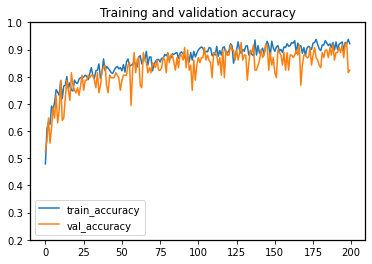

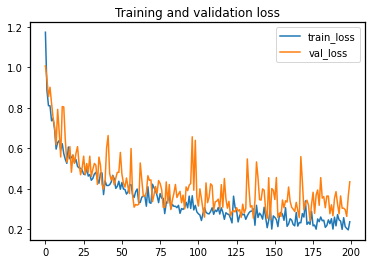

14/14 [==============================] - 2s 119ms/step - loss: 0.3369 - accuracy: 0.8704

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/200
54/54 [==============================] - 11s 159ms/step - loss: 1.1075 - accuracy: 0.5093 - val_loss: 1.0493 - val_accuracy: 0.4444

Epoch 00001: val_accuracy improved from -inf to 0.44444, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5
Epoch 2/200
54/54 [==============================] - 8s 149ms/step - loss: 0.8789 - accuracy: 0.5995 - val_loss: 0.9416 - val_accuracy: 0.5556

Epoch 00002: val_accuracy improved from 0.44444 to 0.55556, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5
Epoch 3/200
54/54 [==============================] - 8s 149ms/step - loss: 0.8112 - accuracy: 0.6551 - val_loss: 0.8430 - val_accuracy: 0.6296

Epoch 00003: val_accuracy improved from 0.55556 to 0.62963, saving model to C:/Users/u

54/54 [==============================] - 10s 178ms/step - loss: 0.4377 - accuracy: 0.8148 - val_loss: 0.6030 - val_accuracy: 0.7407

Epoch 00037: val_accuracy did not improve from 0.80556
Epoch 38/200
54/54 [==============================] - 8s 144ms/step - loss: 0.4228 - accuracy: 0.8495 - val_loss: 0.5336 - val_accuracy: 0.7778

Epoch 00038: val_accuracy did not improve from 0.80556
Epoch 39/200
54/54 [==============================] - 9s 165ms/step - loss: 0.4484 - accuracy: 0.8148 - val_loss: 0.5149 - val_accuracy: 0.7778

Epoch 00039: val_accuracy did not improve from 0.80556
Epoch 40/200
54/54 [==============================] - 9s 153ms/step - loss: 0.4556 - accuracy: 0.8125 - val_loss: 0.5478 - val_accuracy: 0.6944

Epoch 00040: val_accuracy did not improve from 0.80556
Epoch 41/200
54/54 [==============================] - 8s 143ms/step - loss: 0.4344 - accuracy: 0.8218 - val_loss: 0.5576 - val_accuracy: 0.7593

Epoch 00041: val_accuracy did not improve from 0.80556
Epoch 42/200

54/54 [==============================] - 10s 183ms/step - loss: 0.3391 - accuracy: 0.8565 - val_loss: 0.3962 - val_accuracy: 0.8519

Epoch 00076: val_accuracy did not improve from 0.87037
Epoch 77/200
54/54 [==============================] - 9s 167ms/step - loss: 0.2952 - accuracy: 0.8819 - val_loss: 0.4624 - val_accuracy: 0.8333

Epoch 00077: val_accuracy did not improve from 0.87037
Epoch 78/200
54/54 [==============================] - 10s 175ms/step - loss: 0.2969 - accuracy: 0.8866 - val_loss: 0.6200 - val_accuracy: 0.7870

Epoch 00078: val_accuracy did not improve from 0.87037
Epoch 79/200
54/54 [==============================] - 9s 168ms/step - loss: 0.3331 - accuracy: 0.8704 - val_loss: 0.3930 - val_accuracy: 0.8148

Epoch 00079: val_accuracy did not improve from 0.87037
Epoch 80/200
54/54 [==============================] - 10s 177ms/step - loss: 0.3829 - accuracy: 0.8356 - val_loss: 0.4087 - val_accuracy: 0.8333

Epoch 00080: val_accuracy did not improve from 0.87037
Epoch 81/2


Epoch 00115: val_accuracy did not improve from 0.91667
Epoch 116/200
54/54 [==============================] - 9s 154ms/step - loss: 0.2697 - accuracy: 0.8912 - val_loss: 0.2684 - val_accuracy: 0.9074

Epoch 00116: val_accuracy did not improve from 0.91667
Epoch 117/200
54/54 [==============================] - 10s 177ms/step - loss: 0.2288 - accuracy: 0.9213 - val_loss: 0.3568 - val_accuracy: 0.8611

Epoch 00117: val_accuracy did not improve from 0.91667
Epoch 118/200
54/54 [==============================] - 11s 208ms/step - loss: 0.2885 - accuracy: 0.8912 - val_loss: 0.3222 - val_accuracy: 0.8611

Epoch 00118: val_accuracy did not improve from 0.91667
Epoch 119/200
54/54 [==============================] - 12s 226ms/step - loss: 0.2761 - accuracy: 0.8889 - val_loss: 0.3000 - val_accuracy: 0.8519

Epoch 00119: val_accuracy did not improve from 0.91667
Epoch 120/200
54/54 [==============================] - 10s 182ms/step - loss: 0.2355 - accuracy: 0.9190 - val_loss: 0.3672 - val_accuracy

54/54 [==============================] - 10s 174ms/step - loss: 0.2709 - accuracy: 0.9074 - val_loss: 0.3148 - val_accuracy: 0.8241

Epoch 00156: val_accuracy did not improve from 0.92593
Epoch 157/200
54/54 [==============================] - 8s 150ms/step - loss: 0.2436 - accuracy: 0.9213 - val_loss: 0.2685 - val_accuracy: 0.8704

Epoch 00157: val_accuracy did not improve from 0.92593
Epoch 158/200
54/54 [==============================] - 9s 164ms/step - loss: 0.2702 - accuracy: 0.8958 - val_loss: 0.3382 - val_accuracy: 0.8611

Epoch 00158: val_accuracy did not improve from 0.92593
Epoch 159/200
54/54 [==============================] - 10s 191ms/step - loss: 0.2088 - accuracy: 0.9074 - val_loss: 0.2549 - val_accuracy: 0.8981

Epoch 00159: val_accuracy did not improve from 0.92593
Epoch 160/200
54/54 [==============================] - 11s 201ms/step - loss: 0.2268 - accuracy: 0.9097 - val_loss: 0.2834 - val_accuracy: 0.8796

Epoch 00160: val_accuracy did not improve from 0.92593
Epoch 


Epoch 00196: val_accuracy did not improve from 0.92593
Epoch 197/200
54/54 [==============================] - 9s 174ms/step - loss: 0.2274 - accuracy: 0.9120 - val_loss: 0.3471 - val_accuracy: 0.8704

Epoch 00197: val_accuracy did not improve from 0.92593
Epoch 198/200
54/54 [==============================] - 10s 183ms/step - loss: 0.2042 - accuracy: 0.9190 - val_loss: 0.2690 - val_accuracy: 0.8889

Epoch 00198: val_accuracy did not improve from 0.92593
Epoch 199/200
54/54 [==============================] - 10s 182ms/step - loss: 0.2376 - accuracy: 0.8981 - val_loss: 0.3208 - val_accuracy: 0.8796

Epoch 00199: val_accuracy did not improve from 0.92593
Epoch 200/200
54/54 [==============================] - 10s 192ms/step - loss: 0.1836 - accuracy: 0.9375 - val_loss: 0.2543 - val_accuracy: 0.8981

Epoch 00200: val_accuracy did not improve from 0.92593


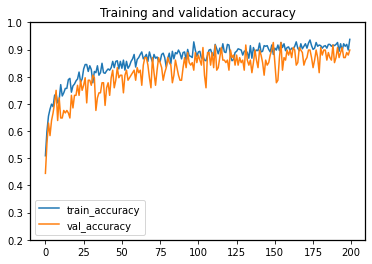

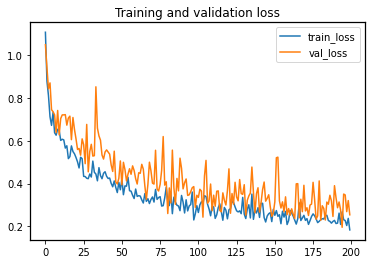

14/14 [==============================] - 2s 145ms/step - loss: 0.2693 - accuracy: 0.8704

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/200
54/54 [==============================] - 14s 182ms/step - loss: 1.0690 - accuracy: 0.5278 - val_loss: 1.0442 - val_accuracy: 0.3981

Epoch 00001: val_accuracy improved from -inf to 0.39815, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_3.h5
Epoch 2/200
54/54 [==============================] - 9s 158ms/step - loss: 0.8801 - accuracy: 0.6157 - val_loss: 0.9001 - val_accuracy: 0.5833

Epoch 00002: val_accuracy improved from 0.39815 to 0.58333, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_3.h5
Epoch 3/200
54/54 [==============================] - 9s 174ms/step - loss: 0.8522 - accuracy: 0.6435 - val_loss: 0.8367 - val_accuracy: 0.6759

Epoch 00003: val_accuracy improved from 0.58333 to 0.67593, saving model to C:/Users/u

54/54 [==============================] - 8s 155ms/step - loss: 0.4347 - accuracy: 0.8241 - val_loss: 0.3431 - val_accuracy: 0.8333

Epoch 00037: val_accuracy did not improve from 0.87963
Epoch 38/200
54/54 [==============================] - 10s 182ms/step - loss: 0.4719 - accuracy: 0.8241 - val_loss: 0.3865 - val_accuracy: 0.8241

Epoch 00038: val_accuracy did not improve from 0.87963
Epoch 39/200
54/54 [==============================] - 9s 171ms/step - loss: 0.4802 - accuracy: 0.7940 - val_loss: 0.4166 - val_accuracy: 0.8333

Epoch 00039: val_accuracy did not improve from 0.87963
Epoch 40/200
54/54 [==============================] - 10s 177ms/step - loss: 0.4754 - accuracy: 0.8125 - val_loss: 0.3566 - val_accuracy: 0.8796

Epoch 00040: val_accuracy did not improve from 0.87963
Epoch 41/200
54/54 [==============================] - 10s 191ms/step - loss: 0.4595 - accuracy: 0.8032 - val_loss: 0.3363 - val_accuracy: 0.8704

Epoch 00041: val_accuracy did not improve from 0.87963
Epoch 42/2

54/54 [==============================] - 12s 212ms/step - loss: 0.3781 - accuracy: 0.8519 - val_loss: 0.2986 - val_accuracy: 0.8981

Epoch 00077: val_accuracy did not improve from 0.94444
Epoch 78/200
54/54 [==============================] - 9s 171ms/step - loss: 0.3971 - accuracy: 0.8426 - val_loss: 0.3180 - val_accuracy: 0.8981

Epoch 00078: val_accuracy did not improve from 0.94444
Epoch 79/200
54/54 [==============================] - 9s 163ms/step - loss: 0.3293 - accuracy: 0.8681 - val_loss: 0.3082 - val_accuracy: 0.8704

Epoch 00079: val_accuracy did not improve from 0.94444
Epoch 80/200
54/54 [==============================] - 9s 168ms/step - loss: 0.3484 - accuracy: 0.8704 - val_loss: 0.2844 - val_accuracy: 0.9259

Epoch 00080: val_accuracy did not improve from 0.94444
Epoch 81/200
54/54 [==============================] - 12s 215ms/step - loss: 0.3951 - accuracy: 0.8426 - val_loss: 0.2958 - val_accuracy: 0.8981

Epoch 00081: val_accuracy did not improve from 0.94444
Epoch 82/20

54/54 [==============================] - 10s 173ms/step - loss: 0.3351 - accuracy: 0.8773 - val_loss: 0.2614 - val_accuracy: 0.8889

Epoch 00118: val_accuracy did not improve from 0.94444
Epoch 119/200
54/54 [==============================] - 10s 182ms/step - loss: 0.3251 - accuracy: 0.8588 - val_loss: 0.3394 - val_accuracy: 0.8426

Epoch 00119: val_accuracy did not improve from 0.94444
Epoch 120/200
54/54 [==============================] - 11s 193ms/step - loss: 0.3048 - accuracy: 0.8819 - val_loss: 0.1767 - val_accuracy: 0.9352

Epoch 00120: val_accuracy did not improve from 0.94444
Epoch 121/200
54/54 [==============================] - 10s 188ms/step - loss: 0.3246 - accuracy: 0.8750 - val_loss: 0.2332 - val_accuracy: 0.8981

Epoch 00121: val_accuracy did not improve from 0.94444
Epoch 122/200
54/54 [==============================] - 9s 162ms/step - loss: 0.2985 - accuracy: 0.8889 - val_loss: 0.1717 - val_accuracy: 0.9444

Epoch 00122: val_accuracy did not improve from 0.94444
Epoch

54/54 [==============================] - 10s 187ms/step - loss: 0.2748 - accuracy: 0.8935 - val_loss: 0.2405 - val_accuracy: 0.8981

Epoch 00158: val_accuracy did not improve from 0.97222
Epoch 159/200
54/54 [==============================] - 8s 152ms/step - loss: 0.2630 - accuracy: 0.9097 - val_loss: 0.1913 - val_accuracy: 0.9537

Epoch 00159: val_accuracy did not improve from 0.97222
Epoch 160/200
54/54 [==============================] - 10s 180ms/step - loss: 0.2692 - accuracy: 0.8796 - val_loss: 0.4122 - val_accuracy: 0.8056

Epoch 00160: val_accuracy did not improve from 0.97222
Epoch 161/200
54/54 [==============================] - 11s 196ms/step - loss: 0.2410 - accuracy: 0.9120 - val_loss: 0.2666 - val_accuracy: 0.8981

Epoch 00161: val_accuracy did not improve from 0.97222
Epoch 162/200
54/54 [==============================] - 9s 162ms/step - loss: 0.2398 - accuracy: 0.9190 - val_loss: 0.2006 - val_accuracy: 0.8981

Epoch 00162: val_accuracy did not improve from 0.97222
Epoch 


Epoch 00198: val_accuracy did not improve from 0.97222
Epoch 199/200
54/54 [==============================] - 8s 153ms/step - loss: 0.2678 - accuracy: 0.9028 - val_loss: 0.1304 - val_accuracy: 0.9537

Epoch 00199: val_accuracy did not improve from 0.97222
Epoch 200/200
54/54 [==============================] - 9s 163ms/step - loss: 0.3021 - accuracy: 0.8866 - val_loss: 0.1580 - val_accuracy: 0.9259

Epoch 00200: val_accuracy did not improve from 0.97222


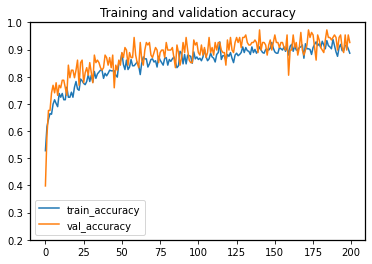

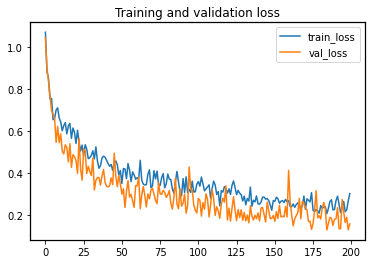

14/14 [==============================] - 2s 124ms/step - loss: 0.2134 - accuracy: 0.9167

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/200
54/54 [==============================] - 13s 173ms/step - loss: 1.0101 - accuracy: 0.5370 - val_loss: 1.1123 - val_accuracy: 0.4167

Epoch 00001: val_accuracy improved from -inf to 0.41667, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5
Epoch 2/200
54/54 [==============================] - 9s 166ms/step - loss: 0.8291 - accuracy: 0.6389 - val_loss: 0.9562 - val_accuracy: 0.4722

Epoch 00002: val_accuracy improved from 0.41667 to 0.47222, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5
Epoch 3/200
54/54 [==============================] - 10s 174ms/step - loss: 0.8626 - accuracy: 0.6458 - val_loss: 0.7114 - val_accuracy: 0.7222

Epoch 00003: val_accuracy improved from 0.47222 to 0.72222, saving model to C:/Users/


Epoch 00036: val_accuracy did not improve from 0.89815
Epoch 37/200
54/54 [==============================] - 8s 154ms/step - loss: 0.4656 - accuracy: 0.7963 - val_loss: 0.3984 - val_accuracy: 0.8519

Epoch 00037: val_accuracy did not improve from 0.89815
Epoch 38/200
54/54 [==============================] - 9s 167ms/step - loss: 0.4106 - accuracy: 0.8495 - val_loss: 0.3688 - val_accuracy: 0.8519

Epoch 00038: val_accuracy did not improve from 0.89815
Epoch 39/200
54/54 [==============================] - 10s 172ms/step - loss: 0.4656 - accuracy: 0.8148 - val_loss: 0.3777 - val_accuracy: 0.8704

Epoch 00039: val_accuracy did not improve from 0.89815
Epoch 40/200
54/54 [==============================] - 9s 156ms/step - loss: 0.4357 - accuracy: 0.8287 - val_loss: 0.3640 - val_accuracy: 0.8796

Epoch 00040: val_accuracy did not improve from 0.89815
Epoch 41/200
54/54 [==============================] - 9s 158ms/step - loss: 0.4508 - accuracy: 0.8148 - val_loss: 0.3647 - val_accuracy: 0.8796

54/54 [==============================] - 8s 151ms/step - loss: 0.3960 - accuracy: 0.8472 - val_loss: 0.3267 - val_accuracy: 0.8796

Epoch 00077: val_accuracy did not improve from 0.91667
Epoch 78/200
54/54 [==============================] - 9s 157ms/step - loss: 0.3287 - accuracy: 0.8889 - val_loss: 0.4472 - val_accuracy: 0.8333

Epoch 00078: val_accuracy did not improve from 0.91667
Epoch 79/200
54/54 [==============================] - 9s 154ms/step - loss: 0.3732 - accuracy: 0.8657 - val_loss: 0.3216 - val_accuracy: 0.8611

Epoch 00079: val_accuracy did not improve from 0.91667
Epoch 80/200
54/54 [==============================] - 9s 173ms/step - loss: 0.3052 - accuracy: 0.8866 - val_loss: 0.2812 - val_accuracy: 0.8981

Epoch 00080: val_accuracy did not improve from 0.91667
Epoch 81/200
54/54 [==============================] - 10s 173ms/step - loss: 0.3238 - accuracy: 0.8750 - val_loss: 0.2942 - val_accuracy: 0.8796

Epoch 00081: val_accuracy did not improve from 0.91667
Epoch 82/200

Epoch 118/200
54/54 [==============================] - 9s 171ms/step - loss: 0.3045 - accuracy: 0.8935 - val_loss: 0.3674 - val_accuracy: 0.8704

Epoch 00118: val_accuracy did not improve from 0.94444
Epoch 119/200
54/54 [==============================] - 9s 173ms/step - loss: 0.2795 - accuracy: 0.8958 - val_loss: 0.3013 - val_accuracy: 0.8519

Epoch 00119: val_accuracy did not improve from 0.94444
Epoch 120/200
54/54 [==============================] - 9s 164ms/step - loss: 0.2684 - accuracy: 0.8912 - val_loss: 0.3128 - val_accuracy: 0.8889

Epoch 00120: val_accuracy did not improve from 0.94444
Epoch 121/200
54/54 [==============================] - 9s 172ms/step - loss: 0.2964 - accuracy: 0.8958 - val_loss: 0.3241 - val_accuracy: 0.8796

Epoch 00121: val_accuracy did not improve from 0.94444
Epoch 122/200
54/54 [==============================] - 9s 163ms/step - loss: 0.2324 - accuracy: 0.9167 - val_loss: 0.2435 - val_accuracy: 0.9074

Epoch 00122: val_accuracy did not improve from 0.9


Epoch 00158: val_accuracy did not improve from 0.94444
Epoch 159/200
54/54 [==============================] - 9s 169ms/step - loss: 0.2070 - accuracy: 0.9051 - val_loss: 0.4440 - val_accuracy: 0.8426

Epoch 00159: val_accuracy did not improve from 0.94444
Epoch 160/200
54/54 [==============================] - 10s 176ms/step - loss: 0.2438 - accuracy: 0.9144 - val_loss: 0.2344 - val_accuracy: 0.9167

Epoch 00160: val_accuracy did not improve from 0.94444
Epoch 161/200
54/54 [==============================] - 9s 163ms/step - loss: 0.2214 - accuracy: 0.9167 - val_loss: 0.2339 - val_accuracy: 0.9259

Epoch 00161: val_accuracy did not improve from 0.94444
Epoch 162/200
54/54 [==============================] - 9s 170ms/step - loss: 0.2961 - accuracy: 0.8843 - val_loss: 0.2220 - val_accuracy: 0.9074

Epoch 00162: val_accuracy did not improve from 0.94444
Epoch 163/200
54/54 [==============================] - 9s 158ms/step - loss: 0.2504 - accuracy: 0.9190 - val_loss: 0.3172 - val_accuracy: 0

54/54 [==============================] - 9s 171ms/step - loss: 0.2299 - accuracy: 0.9236 - val_loss: 0.2240 - val_accuracy: 0.9259

Epoch 00199: val_accuracy did not improve from 0.94444
Epoch 200/200
54/54 [==============================] - 9s 166ms/step - loss: 0.2309 - accuracy: 0.9074 - val_loss: 0.4049 - val_accuracy: 0.8611

Epoch 00200: val_accuracy did not improve from 0.94444


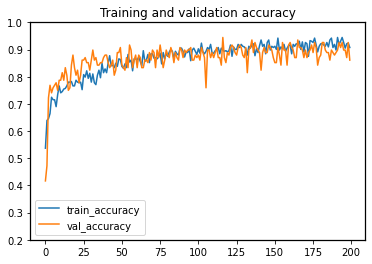

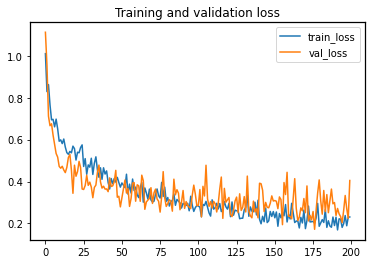

14/14 [==============================] - 2s 122ms/step - loss: 0.2992 - accuracy: 0.8796

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/200
54/54 [==============================] - 16s 230ms/step - loss: 1.0518 - accuracy: 0.5046 - val_loss: 1.0034 - val_accuracy: 0.6019

Epoch 00001: val_accuracy improved from -inf to 0.60185, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5
Epoch 2/200
54/54 [==============================] - 9s 160ms/step - loss: 0.8697 - accuracy: 0.5926 - val_loss: 0.8678 - val_accuracy: 0.6852

Epoch 00002: val_accuracy improved from 0.60185 to 0.68519, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5
Epoch 3/200
54/54 [==============================] - 10s 178ms/step - loss: 0.7717 - accuracy: 0.6736 - val_loss: 0.7042 - val_accuracy: 0.7407

Epoch 00003: val_accuracy improved from 0.68519 to 0.74074, saving model to C:/Users/

Epoch 37/200
54/54 [==============================] - 10s 192ms/step - loss: 0.4029 - accuracy: 0.8310 - val_loss: 0.3584 - val_accuracy: 0.8704

Epoch 00037: val_accuracy did not improve from 0.89815
Epoch 38/200
54/54 [==============================] - 10s 176ms/step - loss: 0.4368 - accuracy: 0.8287 - val_loss: 0.3294 - val_accuracy: 0.8704

Epoch 00038: val_accuracy did not improve from 0.89815
Epoch 39/200
54/54 [==============================] - 12s 213ms/step - loss: 0.4568 - accuracy: 0.8241 - val_loss: 0.4126 - val_accuracy: 0.8426

Epoch 00039: val_accuracy did not improve from 0.89815
Epoch 40/200
54/54 [==============================] - 10s 184ms/step - loss: 0.4504 - accuracy: 0.8218 - val_loss: 0.3291 - val_accuracy: 0.8796

Epoch 00040: val_accuracy did not improve from 0.89815
Epoch 41/200
54/54 [==============================] - 9s 168ms/step - loss: 0.4224 - accuracy: 0.8102 - val_loss: 0.3794 - val_accuracy: 0.8611

Epoch 00041: val_accuracy did not improve from 0.89


Epoch 00076: val_accuracy did not improve from 0.95370
Epoch 77/200
54/54 [==============================] - 10s 188ms/step - loss: 0.3820 - accuracy: 0.8241 - val_loss: 0.2490 - val_accuracy: 0.9167

Epoch 00077: val_accuracy did not improve from 0.95370
Epoch 78/200
54/54 [==============================] - 12s 213ms/step - loss: 0.3708 - accuracy: 0.8565 - val_loss: 0.2622 - val_accuracy: 0.9444

Epoch 00078: val_accuracy did not improve from 0.95370
Epoch 79/200
54/54 [==============================] - 11s 205ms/step - loss: 0.3689 - accuracy: 0.8519 - val_loss: 0.2314 - val_accuracy: 0.9352

Epoch 00079: val_accuracy did not improve from 0.95370
Epoch 80/200
54/54 [==============================] - 11s 197ms/step - loss: 0.3889 - accuracy: 0.8380 - val_loss: 0.3467 - val_accuracy: 0.8519

Epoch 00080: val_accuracy did not improve from 0.95370
Epoch 81/200
54/54 [==============================] - 11s 194ms/step - loss: 0.3660 - accuracy: 0.8588 - val_loss: 0.2545 - val_accuracy: 0.

54/54 [==============================] - 12s 221ms/step - loss: 0.2826 - accuracy: 0.9028 - val_loss: 0.2375 - val_accuracy: 0.9167

Epoch 00117: val_accuracy did not improve from 0.96296
Epoch 118/200
54/54 [==============================] - 11s 197ms/step - loss: 0.2739 - accuracy: 0.8796 - val_loss: 0.2830 - val_accuracy: 0.9074

Epoch 00118: val_accuracy did not improve from 0.96296
Epoch 119/200
54/54 [==============================] - 12s 217ms/step - loss: 0.3057 - accuracy: 0.8889 - val_loss: 0.1771 - val_accuracy: 0.9259

Epoch 00119: val_accuracy did not improve from 0.96296
Epoch 120/200
54/54 [==============================] - 11s 205ms/step - loss: 0.2868 - accuracy: 0.8889 - val_loss: 0.1838 - val_accuracy: 0.9352

Epoch 00120: val_accuracy did not improve from 0.96296
Epoch 121/200
54/54 [==============================] - 10s 186ms/step - loss: 0.3081 - accuracy: 0.8889 - val_loss: 0.2415 - val_accuracy: 0.9074

Epoch 00121: val_accuracy did not improve from 0.96296
Epoc


Epoch 00157: val_accuracy did not improve from 0.96296
Epoch 158/200
54/54 [==============================] - 11s 209ms/step - loss: 0.2431 - accuracy: 0.9097 - val_loss: 0.1920 - val_accuracy: 0.9537

Epoch 00158: val_accuracy did not improve from 0.96296
Epoch 159/200
54/54 [==============================] - 11s 199ms/step - loss: 0.2012 - accuracy: 0.9282 - val_loss: 0.1828 - val_accuracy: 0.9352

Epoch 00159: val_accuracy did not improve from 0.96296
Epoch 160/200
54/54 [==============================] - 11s 211ms/step - loss: 0.2845 - accuracy: 0.8912 - val_loss: 0.1767 - val_accuracy: 0.9167

Epoch 00160: val_accuracy did not improve from 0.96296
Epoch 161/200
54/54 [==============================] - 16s 302ms/step - loss: 0.2197 - accuracy: 0.9259 - val_loss: 0.2017 - val_accuracy: 0.9167

Epoch 00161: val_accuracy did not improve from 0.96296
Epoch 162/200
54/54 [==============================] - 13s 238ms/step - loss: 0.2662 - accuracy: 0.9051 - val_loss: 0.1849 - val_accurac

54/54 [==============================] - 11s 200ms/step - loss: 0.2065 - accuracy: 0.9282 - val_loss: 0.1501 - val_accuracy: 0.9537

Epoch 00198: val_accuracy did not improve from 0.97222
Epoch 199/200
54/54 [==============================] - 13s 236ms/step - loss: 0.2181 - accuracy: 0.9190 - val_loss: 0.1721 - val_accuracy: 0.9630

Epoch 00199: val_accuracy did not improve from 0.97222
Epoch 200/200
54/54 [==============================] - 12s 220ms/step - loss: 0.2228 - accuracy: 0.9144 - val_loss: 0.1759 - val_accuracy: 0.9444

Epoch 00200: val_accuracy did not improve from 0.97222


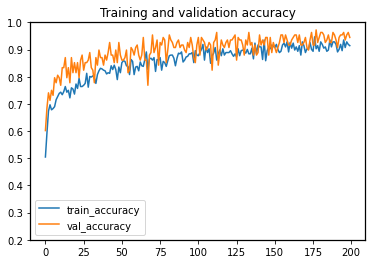

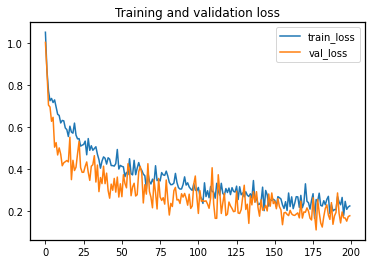

14/14 [==============================] - 3s 188ms/step - loss: 0.1256 - accuracy: 0.9630


In [21]:
for x in range(len(batch_size_arr)):
    
    #for batch size values
    if len(param_arr) == 0:
        param_arr.append([])
    
    for y in range(len(num_epochs_arr)):

        #for epoch values
        if len(param_arr) == 1:
            param_arr.append([])
        
        for z in range(len(lr_arr)):
            
            #for learning rate values
            if len(param_arr) == 2:
                param_arr.append([])
               
            print('')
            print("batch size: ", batch_size_arr[x])
            print("epochs: ", num_epochs_arr[y])
            print("learning rate: ", lr_arr[z])
            print('')
            
            #append the values per combo
            param_arr[0].append(batch_size_arr[x])
            param_arr[1].append(num_epochs_arr[y])
            param_arr[2].append(lr_arr[z])
            
            VALIDATION_ACCURACY = []
            VALIDATION_LOSS = []
            
            TRAIN_ACCURACY = []
            TRAIN_LOSS = []
            
            TEST_ACCURACY = []
            TEST_LOSS = []
            
            #change save_dir value per combination
            save_dir = savemodel()
            fold_var = 1
            
            for train_index, val_index in skf.split(np.zeros(len(df2)),Y):
                
                #continuously split the dataset to train set and validation set in n folds
                training_data = df2.iloc[train_index]
                validation_data = df2.iloc[val_index]
                
                print('')
                print("Fold number " + str(fold_var))
                
                #apply data augmentation to both train set and validation set
                train_data_generator = imgdatagen.flow_from_dataframe(training_data, directory = train_dir,
                                       x_col = "filename", y_col = "label",
                                       class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                valid_data_generator  = imgdatagen.flow_from_dataframe(validation_data, directory = train_dir,
                                        x_col = "filename", y_col = "label",
                                        class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                
                #use the created model
                full_model = create_model()
                
                #compile the model
                full_model.compile(loss='categorical_crossentropy',
                              optimizer=keras.optimizers.Adamax(learning_rate=lr_arr[z]),
                              metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

                #create callbacks
                checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "model_" + str(fold_var) + ".h5"), 
                                        monitor='val_accuracy', verbose=1, 
                                        save_best_only=True, mode='max')
                callbacks_list = [checkpoint]
                #this saves the best model


                #fit the model
                history = full_model.fit(train_data_generator,
                                         epochs=num_epochs_arr[y],
                                         callbacks=callbacks_list,
                                         validation_data=valid_data_generator,
                                         verbose=1)

                #plot the history
                plot_history(history, yrange=(0.2,1))

                #load the best model instance to evaluate the performance of the model
                full_model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")

                results = full_model.evaluate(valid_data_generator)
                results = dict(zip(full_model.metrics_names,results))
                
                #store Validation accuracy/loss
                VALIDATION_ACCURACY.append(results['accuracy'])
                VALIDATION_LOSS.append(results['loss'])
                
                #store Train accuracy/loss
                TRAIN_ACCURACY.append(np.mean(history.history['accuracy']))
                TRAIN_LOSS.append(np.mean(history.history['loss']))
                
                #predict test set to get the test accuracy/loss
                yhat_probs = full_model.predict(testX, verbose=0) 
                yhat_classes = yhat_probs.argmax(axis=-1)
                
                #test accuracy and loss score
                accuracy = accuracy_score(yt, yhat_classes)
                loss = log_loss(yt, yhat_probs)
                
                #store Test accuracy and loss
                TEST_ACCURACY.append(accuracy)
                TEST_LOSS.append(loss)
                
                tf.keras.backend.clear_session()

                fold_var += 1
            
            #store the all accuracy and loss in all folds per combination
            val_acc_arr.append(VALIDATION_ACCURACY)
            val_loss_arr.append(VALIDATION_LOSS)
            
            train_acc_arr.append(TRAIN_ACCURACY)                            
            train_loss_arr.append(TRAIN_LOSS)
            
            test_acc_arr.append(TEST_ACCURACY)
            test_loss_arr.append(TEST_LOSS)

In [22]:
#stopper

### Display Values Per Combination of Hyperparameters

We will put the combination of hyperparameters and the resulting means of accuracy and loss together in a dataframe in order to display it nicely.

In [23]:
#append means of accuracy and loss per combo
for x in range(len(val_acc_arr)):
    val_acc_means.append(np.mean(val_acc_arr[x]))                                
    val_loss_means.append(np.mean(val_loss_arr[x]))
    
    train_acc_means.append(np.mean(train_acc_arr[x]))                              
    train_loss_means.append(np.mean(train_loss_arr[x]))                             

    test_acc_means.append(np.mean(test_acc_arr[x]))                               
    test_loss_means.append(np.mean(test_loss_arr[x])) 
    
df_hyperparam = pd.DataFrame(list(zip(param_arr[0],param_arr[1],param_arr[2],
                                      train_acc_means, train_loss_means,
                                      val_acc_means,val_loss_means,
                                      test_acc_means, test_loss_means))
                             ,columns=['batch size','number of epoch', 'learning rate', 
                                       'train accuracy', 'train loss',
                                       'val accuracy', 'val loss',
                                       'test accuracy', 'test loss'])

df_hyperparam = df_hyperparam.sort_values(ascending=False,by = 'val accuracy')

#df_hyperparam.to_excel("hyperparam_result.xlsx")

df_hyperparam

,batch size,number of epoch,learning rate,train accuracy,train loss,val accuracy,val loss,test accuracy,test loss
0,8,200,0.0001,0.860692,0.351404,0.9,0.248876,0.863333,0.319533


In [24]:
#stopper

### Each fold results of best combination

Below are the validation accuracy and validation loss per fold and their average of the best combination.

In [25]:
#get the index of the best combination
comb_no = df_hyperparam.loc[[df_hyperparam['val accuracy'].idxmax()]].index.tolist()[0]
fold_num = [*range(1,6)]

fold_eval = pd.DataFrame(list(zip(fold_num,train_acc_arr[comb_no],train_loss_arr[comb_no],
                                  val_acc_arr[comb_no],val_loss_arr[comb_no],
                                  test_acc_arr[comb_no],test_loss_arr[comb_no]))
                         ,columns=['fold','Training Accuracy','Training Loss',
                                   'Validation Accuracy','Validation Loss',
                                   'Test Accuracy','Test Loss'])

fold_eval.set_index('fold', inplace=True)
fold_eval.loc['mean'] = fold_eval.mean()

#fold_eval.to_excel('fold_eval.xlsx')
fold_eval

,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss
fold,,,,,,
1,0.862512,0.351376,0.870370,0.336898,0.833333,0.323546
2,0.864248,0.342371,0.870370,0.269304,0.833333,0.366154
3,0.852396,0.369143,0.916667,0.213370,0.883333,0.271181
4,0.867940,0.337231,0.879630,0.299185,0.850000,0.339493
5,0.856366,0.356898,0.962963,0.125622,0.916667,0.297290
mean,0.860692,0.351404,0.900000,0.248876,0.863333,0.319533


In [26]:
#stopper

## Final Model

We will use the best combination of hypaparameters to train our final model. We will evaluate the model using the train set.

### Get best combination of hyperparameters

In [27]:
df_bestohypaparamu = df_hyperparam.loc[[df_hyperparam['val accuracy'].idxmax()]]

bestohypaparamu = [df_bestohypaparamu['batch size'].values[0],
                   df_bestohypaparamu['number of epoch'].values[0],
                   df_bestohypaparamu['learning rate'].values[0]]

### Train and Predict the model

The same as to what was done in the hyperparameter tuning, we will split the train set to train and validation set with the same random state of 69 in order to have a similar resulting accuracy and loss.

In [28]:
# Split train set to train set and valid set
X = df2[['filename']]
y = df2[['label']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

We will save the images from the new train set and validation set to separate folders.

In [29]:
#folder to store the train and test set folders
fortraintest2 = directory + "/ToBeUsedFinalModel"
if not os.path.exists(fortraintest2):
    os.makedirs(fortraintest2)

#train set folder
tr2 = fortraintest2 + "/train_set"
if not os.path.exists(tr2):
    os.makedirs(tr2)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr2)
    os.makedirs(tr2)
    
#test set folder
va = fortraintest2 + "/val_set"
if not os.path.exists(va):
    os.makedirs(va)
else:
    #remove previous folder and create new one
    shutil.rmtree(va)
    os.makedirs(va)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    try:
        trcpy = shutil.copy2(row['filename'], tr2)
    except shutil.SameFileError:
        pass
    
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_val.iterrows():
    try:
        vacpy = shutil.copy2(row['filename'], va)
    except shutil.SameFileError:
        pass
    
    X_val.loc[X_val['filename']==row['filename'],'filename']=vacpy #change to directory where image is copied

### Train Set Final Model

In [30]:
df4 = pd.concat([X_train,y_train],axis=1)
df4

,filename,label
547,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
382,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
218,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
549,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
468,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
...,...,...
322,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
269,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
127,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
442,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2


In [31]:
counto = [0,0,0]

counto_count = 0

df4_lbl = sorted(df4['label'].unique(), reverse=False) 

for x in df4_lbl:
    for y in df4['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1
    
print(counto)

[144, 144, 144]


### Validation Set Final Model

In [32]:
df5 = pd.concat([X_val,y_val],axis=1)
df5

,filename,label
420,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
27,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
240,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
306,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
354,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
...,...,...
34,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
199,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
336,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
67,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0


In [33]:
counto = [0,0,0]

counto_count = 0

df5_lbl = sorted(df5['label'].unique(), reverse=False) 

for x in df5_lbl:
    for y in df5['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1
    
print(counto)

[36, 36, 36]


Finally we train the model. Prediction is also done using the test set.

Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/200
54/54 [==============================] - 20s 280ms/step - loss: 1.0437 - accuracy: 0.5116 - val_loss: 1.3320 - val_accuracy: 0.4352

Epoch 00001: val_accuracy improved from -inf to 0.43519, saving model to C:/Users/user/Desktop/Model/saved_finalmodel_1\finalmodel_1.h5
Epoch 2/200
54/54 [==============================] - 12s 227ms/step - loss: 0.8379 - accuracy: 0.6319 - val_loss: 0.9996 - val_accuracy: 0.4630

Epoch 00002: val_accuracy improved from 0.43519 to 0.46296, saving model to C:/Users/user/Desktop/Model/saved_finalmodel_1\finalmodel_1.h5
Epoch 3/200
54/54 [==============================] - 14s 250ms/step - loss: 0.7959 - accuracy: 0.6319 - val_loss: 0.8315 - val_accuracy: 0.6019

Epoch 00003: val_accuracy improved from 0.46296 to 0.60185, saving model to C:/Users/user/Desktop/Model/saved_finalmodel_1\finalmodel_1.h5
Epoch 4/200
54/54 [============


Epoch 00036: val_accuracy did not improve from 0.83333
Epoch 37/200
54/54 [==============================] - 15s 276ms/step - loss: 0.4432 - accuracy: 0.8194 - val_loss: 0.5115 - val_accuracy: 0.7778

Epoch 00037: val_accuracy did not improve from 0.83333
Epoch 38/200
54/54 [==============================] - 12s 218ms/step - loss: 0.3941 - accuracy: 0.8565 - val_loss: 0.4650 - val_accuracy: 0.7870

Epoch 00038: val_accuracy did not improve from 0.83333
Epoch 39/200
54/54 [==============================] - 13s 234ms/step - loss: 0.4606 - accuracy: 0.8241 - val_loss: 0.5746 - val_accuracy: 0.7500

Epoch 00039: val_accuracy did not improve from 0.83333
Epoch 40/200
54/54 [==============================] - 14s 259ms/step - loss: 0.3709 - accuracy: 0.8727 - val_loss: 0.4941 - val_accuracy: 0.8148

Epoch 00040: val_accuracy did not improve from 0.83333
Epoch 41/200
54/54 [==============================] - 13s 230ms/step - loss: 0.4573 - accuracy: 0.8125 - val_loss: 0.5289 - val_accuracy: 0.

54/54 [==============================] - 13s 232ms/step - loss: 0.3347 - accuracy: 0.8727 - val_loss: 0.4304 - val_accuracy: 0.8333

Epoch 00076: val_accuracy did not improve from 0.88889
Epoch 77/200
54/54 [==============================] - 10s 190ms/step - loss: 0.3233 - accuracy: 0.8727 - val_loss: 0.4776 - val_accuracy: 0.8148

Epoch 00077: val_accuracy did not improve from 0.88889
Epoch 78/200
54/54 [==============================] - 12s 213ms/step - loss: 0.3021 - accuracy: 0.8843 - val_loss: 0.4128 - val_accuracy: 0.7963

Epoch 00078: val_accuracy did not improve from 0.88889
Epoch 79/200
54/54 [==============================] - 12s 213ms/step - loss: 0.2830 - accuracy: 0.9051 - val_loss: 0.4169 - val_accuracy: 0.8148

Epoch 00079: val_accuracy did not improve from 0.88889
Epoch 80/200
54/54 [==============================] - 11s 204ms/step - loss: 0.3372 - accuracy: 0.8704 - val_loss: 0.4350 - val_accuracy: 0.7963

Epoch 00080: val_accuracy did not improve from 0.88889
Epoch 81

54/54 [==============================] - 14s 251ms/step - loss: 0.2815 - accuracy: 0.9028 - val_loss: 0.4453 - val_accuracy: 0.8241

Epoch 00116: val_accuracy did not improve from 0.89815
Epoch 117/200
54/54 [==============================] - 11s 209ms/step - loss: 0.2975 - accuracy: 0.8634 - val_loss: 0.4701 - val_accuracy: 0.8241

Epoch 00117: val_accuracy did not improve from 0.89815
Epoch 118/200
54/54 [==============================] - 13s 249ms/step - loss: 0.2905 - accuracy: 0.8981 - val_loss: 0.4221 - val_accuracy: 0.8426

Epoch 00118: val_accuracy did not improve from 0.89815
Epoch 119/200
54/54 [==============================] - 13s 236ms/step - loss: 0.2877 - accuracy: 0.8912 - val_loss: 0.2577 - val_accuracy: 0.9074

Epoch 00119: val_accuracy improved from 0.89815 to 0.90741, saving model to C:/Users/user/Desktop/Model/saved_finalmodel_1\finalmodel_1.h5
Epoch 120/200
54/54 [==============================] - 9s 169ms/step - loss: 0.2500 - accuracy: 0.9097 - val_loss: 0.4303 

54/54 [==============================] - 12s 230ms/step - loss: 0.2167 - accuracy: 0.9259 - val_loss: 0.2787 - val_accuracy: 0.8796

Epoch 00156: val_accuracy did not improve from 0.92593
Epoch 157/200
54/54 [==============================] - 16s 287ms/step - loss: 0.1997 - accuracy: 0.9421 - val_loss: 0.2895 - val_accuracy: 0.8426

Epoch 00157: val_accuracy did not improve from 0.92593
Epoch 158/200
54/54 [==============================] - 13s 244ms/step - loss: 0.2516 - accuracy: 0.9097 - val_loss: 0.4234 - val_accuracy: 0.8426

Epoch 00158: val_accuracy did not improve from 0.92593
Epoch 159/200
54/54 [==============================] - 13s 239ms/step - loss: 0.2789 - accuracy: 0.8958 - val_loss: 0.3551 - val_accuracy: 0.8333

Epoch 00159: val_accuracy did not improve from 0.92593
Epoch 160/200
54/54 [==============================] - 13s 247ms/step - loss: 0.2707 - accuracy: 0.8935 - val_loss: 0.4195 - val_accuracy: 0.8333

Epoch 00160: val_accuracy did not improve from 0.92593
Epoc


Epoch 00196: val_accuracy did not improve from 0.92593
Epoch 197/200
54/54 [==============================] - 13s 235ms/step - loss: 0.2091 - accuracy: 0.9259 - val_loss: 0.3616 - val_accuracy: 0.8611

Epoch 00197: val_accuracy did not improve from 0.92593
Epoch 198/200
54/54 [==============================] - 11s 209ms/step - loss: 0.2203 - accuracy: 0.9167 - val_loss: 0.2654 - val_accuracy: 0.8889

Epoch 00198: val_accuracy did not improve from 0.92593
Epoch 199/200
54/54 [==============================] - 13s 240ms/step - loss: 0.2306 - accuracy: 0.9213 - val_loss: 0.3126 - val_accuracy: 0.8426

Epoch 00199: val_accuracy did not improve from 0.92593
Epoch 200/200
54/54 [==============================] - 14s 244ms/step - loss: 0.2139 - accuracy: 0.9167 - val_loss: 0.4269 - val_accuracy: 0.8148

Epoch 00200: val_accuracy did not improve from 0.92593


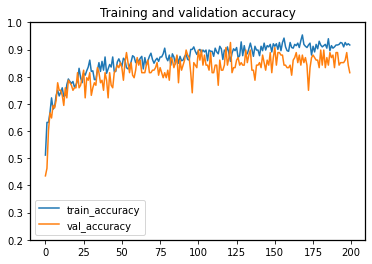

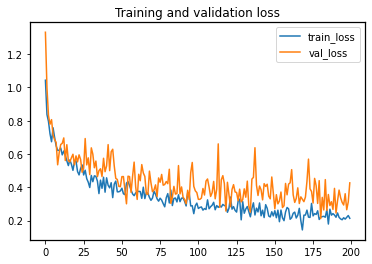

14/14 [==============================] - 2s 123ms/step - loss: 0.3592 - accuracy: 0.8704


In [34]:
VAL_ACCURACY = None
VAL_LOSS = None

train_dir = tr2
valid_dir = va
save_dir = gen_dir + "/saved_finalmodel_1"

if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    
os.makedirs(save_dir)

trainu = df4
validu = df5

train_data_generator = imgdatagen.flow_from_dataframe(trainu, directory = train_dir,
                                       x_col = "filename", y_col = "label",
                                       class_mode = "categorical", target_size = (224,224), batch_size = bestohypaparamu[0],
                                            shuffle = True)
valid_data_generator  = imgdatagen.flow_from_dataframe(validu, directory = valid_dir,
                        x_col = "filename", y_col = "label",
                        class_mode = "categorical", target_size = (224,224), batch_size = bestohypaparamu[0],
                            shuffle = True)

#print(len(train_data_generator))

full_model = create_model()
# Compile the model
full_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(learning_rate=bestohypaparamu[2]),
              metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

# Create callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "finalmodel_1.h5"), 
                        monitor='val_accuracy', verbose=1, 
                        save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# This saves the best model


# Fit the model
history = full_model.fit(train_data_generator,
                         epochs=bestohypaparamu[1],
                         callbacks=callbacks_list,
                         validation_data=valid_data_generator,
                         verbose=1)

# Plot the history
plot_history(history, yrange=(0.2,1))

# Load the best model instance to evaluate the performance of the model
full_model.load_weights(save_dir+"/"+ "finalmodel_1.h5")

results = full_model.evaluate(valid_data_generator)

#print(results)

results = dict(zip(full_model.metrics_names,results))

# Store Validation accuracy/loss
VAL_ACCURACY = results['accuracy']
VAL_LOSS = results['loss']

tf.keras.backend.clear_session()

Display the validation accuracy and loss.

In [35]:
print("Val acc:  " + str(VAL_ACCURACY))
print("Val loss: " + str(VAL_LOSS))

Val acc:  0.8703703880310059
Val loss: 0.3592142164707184


Predict using test set.

In [36]:
save_dir = gen_dir + "/saved_finalmodel_1"
full_model = create_model()
full_model.load_weights(save_dir+"/"+ "finalmodel_1.h5")

# Needed later for measuring performance metrics
# Predict test set to get the test accuracy/loss
yhat_probs2 = full_model.predict(testX, verbose=0) 
yhat_classes2 = yhat_probs2.argmax(axis=-1)

## Measure Performance Metrics

After we have trained the final model with the entire train set and done prediction using the test set, we can now measure the performance metrics for model evaluation.

## Functions

### Accuracy, Precision, Recall

In [37]:
def metriksu(yhat_classes2):
    
    # accuracy: (tp + tn) / (p + n)
    matrix = confusion_matrix(yt, yhat_classes2)
    accuracy2 = matrix.diagonal()/matrix.sum(axis=1)
    print('Accuracy per class: ' + str(accuracy2))
    # precision tp / (tp + fp)
    precision = precision_score(yt, yhat_classes2, average="weighted")
    print('Precision: %f' % precision)
    precision2 = precision_score(yt, yhat_classes2, average=None)
    print('Precision per class: ' + str(precision2))
    # recall: tp / (tp + fn)
    recall = recall_score(yt, yhat_classes2, average="weighted")
    print('Recall: %f' % recall)
    recall2 = recall_score(yt, yhat_classes2, average=None)
    print('Recall per class: ' + str(recall2))
    
    return accuracy2, precision2, recall2

### ROC AUC

In [38]:
def roshi_aushi(yhat_probs2):
    
    # Binarize the true label
    ytbin = label_binarize(yt, classes=[0, 1, 2])
    n_classes = ytbin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
      
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytbin[:, i], yhat_probs2[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i]) 

    # Compute micro-average ROC curve and ROC area
    fpr["macro"], tpr["macro"], _ = roc_curve(ytbin.ravel(), yhat_probs2.ravel())
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25
    
    #balut-penoy
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Balut-Penoy')
    plt.legend(loc="lower right")
    plt.show()

    #salted egg
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Salted Egg')
    plt.legend(loc="lower right")
    plt.show()

    #table egg
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Table Egg')
    plt.legend(loc="lower right")
    plt.show()

### Confusion Matrix

In [39]:
def confuuusion_meytriksu(yhat_classes2):

    #confusion matrix
    matrix = confusion_matrix(yt, yhat_classes2)
    
    df_cm = pd.DataFrame(matrix, range(matrix.shape[0]), range(matrix.shape[1]))
    df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                         index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})
    
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title('Confusion Matrix of Final Model Evaluation')

Call all the functions.

In [40]:
accuracy2, precision2, recall2 = metriksu(yhat_classes2)

Accuracy per class: [1.   0.9  0.65]
Precision: 0.860248
Precision per class: [0.86956522 0.7826087  0.92857143]
Recall: 0.850000
Recall per class: [1.   0.9  0.65]


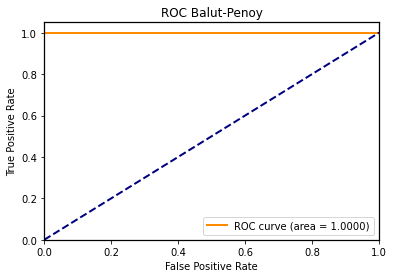

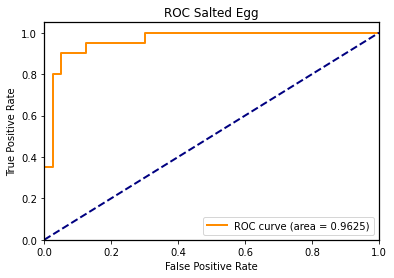

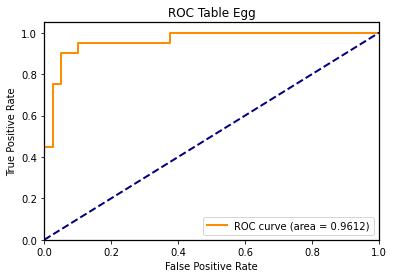

In [41]:
roshi_aushi(yhat_probs2)

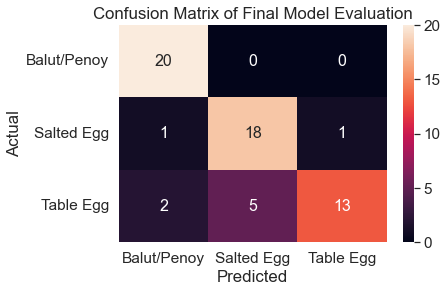

In [42]:
confuuusion_meytriksu(yhat_classes2)

### Metrics per Class

In [43]:
accuracy2 = list(accuracy2)
precision2 = list(precision2)
recall2 = list(recall2)

accuracy2.append(0)
precision2.append(0)
recall2.append(0)

classes = 3

for x in range(classes):
    accuracy2[-1] += accuracy2[x]
    precision2[-1] += precision2[x]
    recall2[-1] += recall2[x]

accuracy2[-1] = accuracy2[-1]/classes
precision2[-1] = precision2[-1]/classes
recall2[-1] = recall2[-1]/classes

In [44]:
label = ['Balut/Penoy','Salted','Table','Ave']

df_eval_per_class = pd.DataFrame(data = list(zip(label,accuracy2,precision2,recall2)), 
                       columns=["Class","Accuracy","Precision","Recall"])

#set fold_ave as the index
df_eval_per_class.set_index("Class",inplace=True)

df_eval_per_class

,Accuracy,Precision,Recall
Class,,,
Balut/Penoy,1.00,0.869565,1.00
Salted,0.90,0.782609,0.90
Table,0.65,0.928571,0.65
Ave,0.85,0.860248,0.85


## Validating Misclassified Images

We will display the correct and incorrect predictions. We will first get the images from the directories stored under the filename column.

In [45]:
testX2 = []

for img_path in X_test['filename']:
    img = cv2.imread(img_path)
    testX2.append(img)

testX2 = np.array(testX2)

We will be applying Grad-CAM in order to check where is the focus of the model. It presents a heatmap. The hotter the color on a region is, the more it is focused on.

### Grad-CAM algorithm

In [46]:
last_conv_layer_name = "conv5_block3_add"

preprocess_input = keras.applications.resnet50.preprocess_input

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

### superimposed visualization

In [47]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

### Prediction

In [48]:
def guraducamu(img_dir):
    img_size = (224,224)

    # Prepare image
    img_array = get_img_array(img_dir, img_size)

    conv_model = keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in conv_model.layers:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(3, activation='softmax',name = "prediction")(x)

    model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

    model.load_weights(save_dir+"/"+ "finalmodel_1.h5")

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
 
    print("Original Image")
    display(Image(img_dir))

    print("Heatmap Prediction")
    plt.matshow(heatmap)
    plt.grid(False)
    plt.axis('off')
    plt.show()

    print("Grad-CAM")
    save_and_display_gradcam(img_dir, heatmap)

### Correct predictions

Found 51 correct labels
Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 79.jpg
Original Image


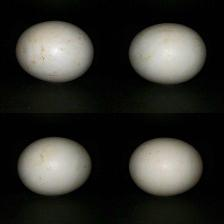

Heatmap Prediction


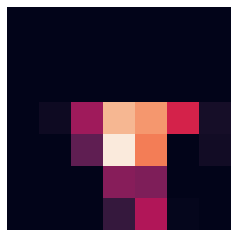

Grad-CAM


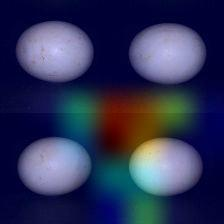

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 66.jpg
Original Image


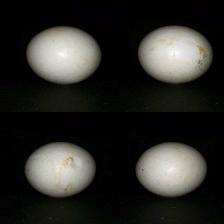

Heatmap Prediction


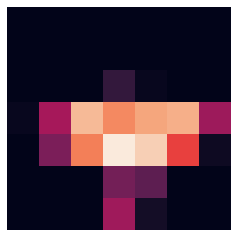

Grad-CAM


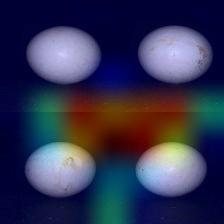

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 188.jpg
Original Image


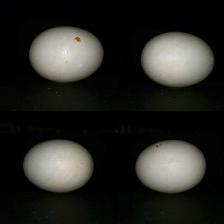

Heatmap Prediction


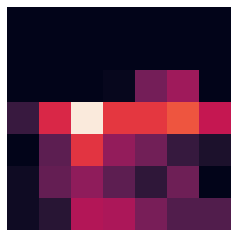

Grad-CAM


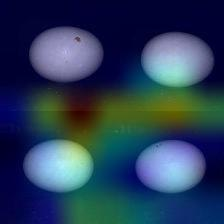

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 150.jpg
Original Image


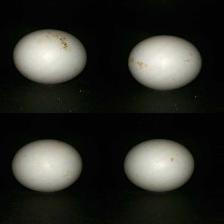

Heatmap Prediction


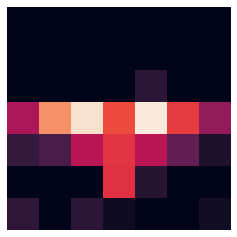

Grad-CAM


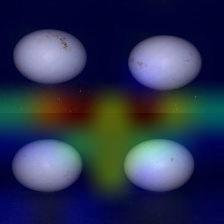

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 4.jpg
Original Image


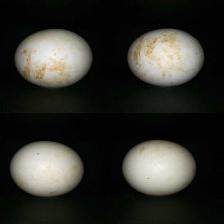

Heatmap Prediction


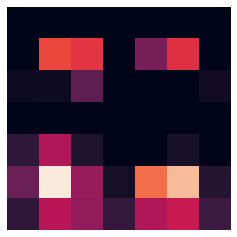

Grad-CAM


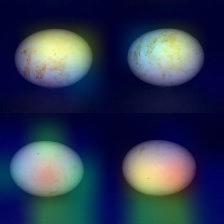

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 188.jpg
Original Image


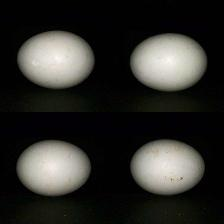

Heatmap Prediction


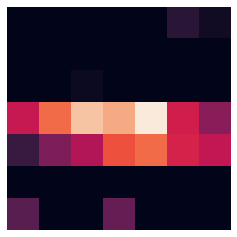

Grad-CAM


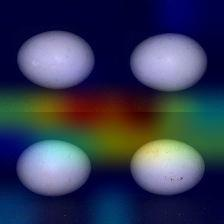

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 108.jpg
Original Image


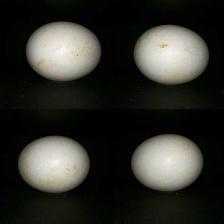

Heatmap Prediction


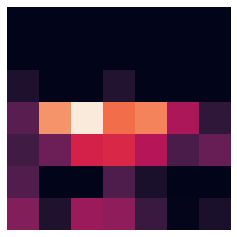

Grad-CAM


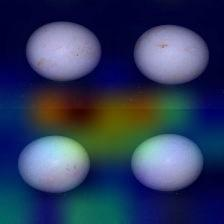

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 58.jpg
Original Image


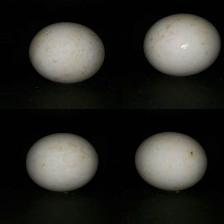

Heatmap Prediction


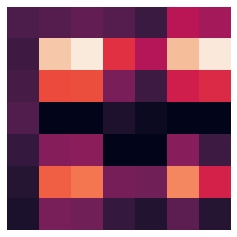

Grad-CAM


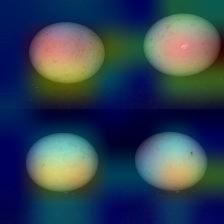

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 32.jpg
Original Image


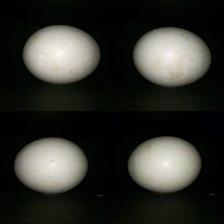

Heatmap Prediction


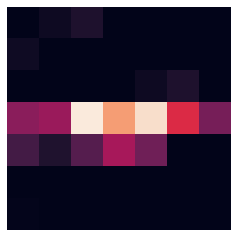

Grad-CAM


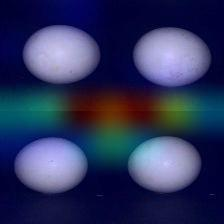

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 52.jpg
Original Image


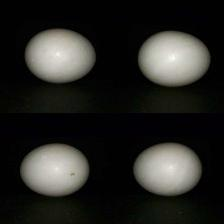

Heatmap Prediction


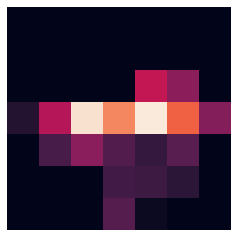

Grad-CAM


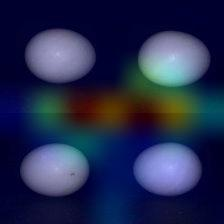

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 167.jpg
Original Image


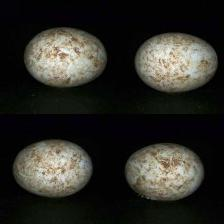

Heatmap Prediction


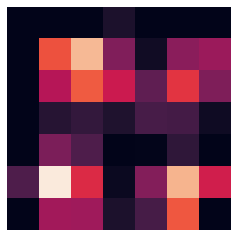

Grad-CAM


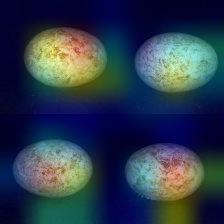

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 47.jpg
Original Image


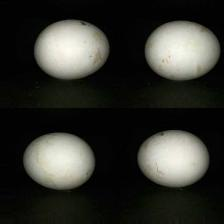

Heatmap Prediction


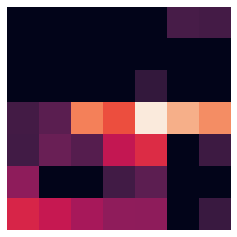

Grad-CAM


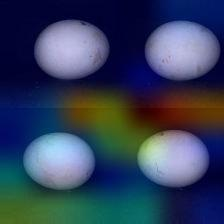

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 56.jpg
Original Image


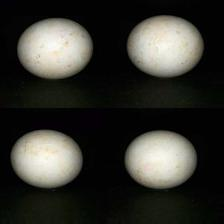

Heatmap Prediction


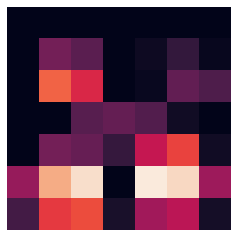

Grad-CAM


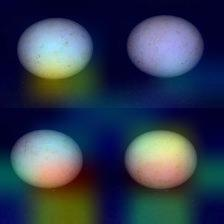

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 156.jpg
Original Image


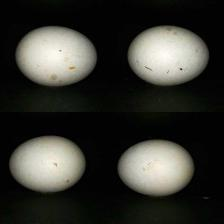

Heatmap Prediction


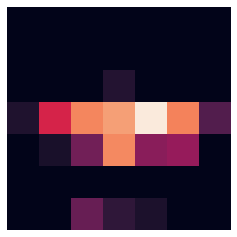

Grad-CAM


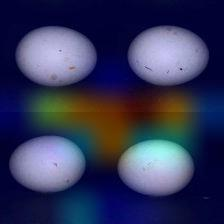

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 6.jpg
Original Image


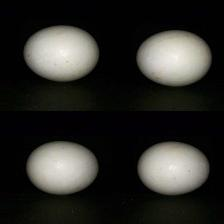

Heatmap Prediction


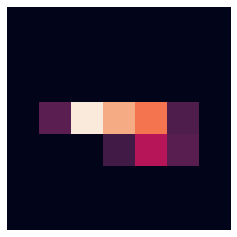

Grad-CAM


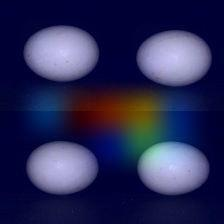

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 22.jpg
Original Image


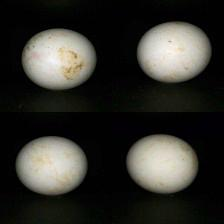

Heatmap Prediction


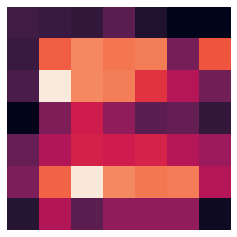

Grad-CAM


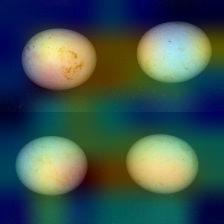

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 64.jpg
Original Image


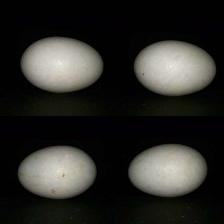

Heatmap Prediction


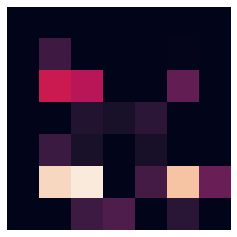

Grad-CAM


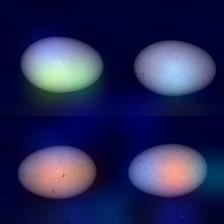

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 32.jpg
Original Image


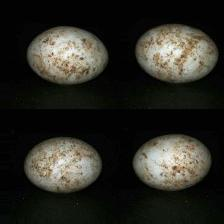

Heatmap Prediction


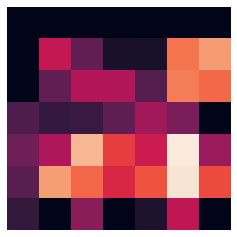

Grad-CAM


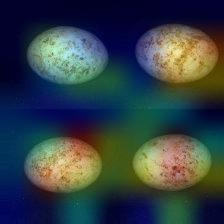

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 17.jpg
Original Image


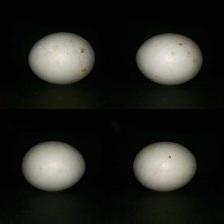

Heatmap Prediction


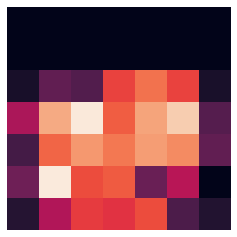

Grad-CAM


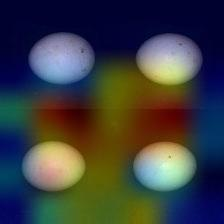

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 195.jpg
Original Image


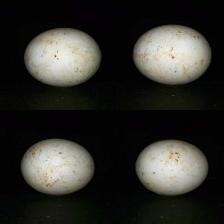

Heatmap Prediction


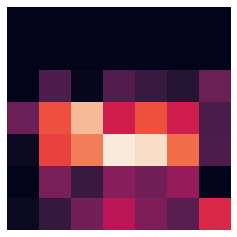

Grad-CAM


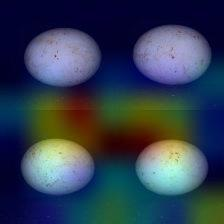

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 130.jpg
Original Image


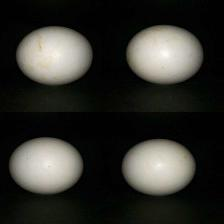

Heatmap Prediction


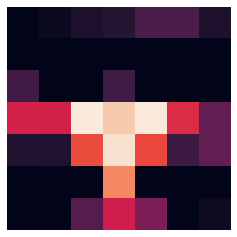

Grad-CAM


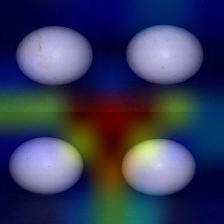

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 17.jpg
Original Image


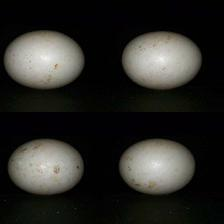

Heatmap Prediction


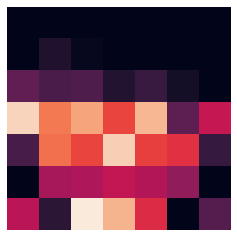

Grad-CAM


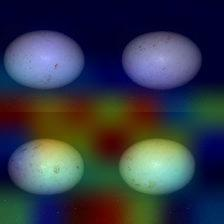

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 112.jpg
Original Image


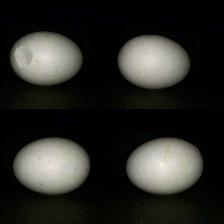

Heatmap Prediction


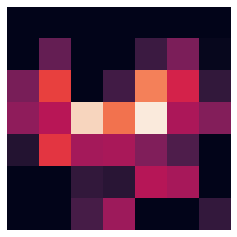

Grad-CAM


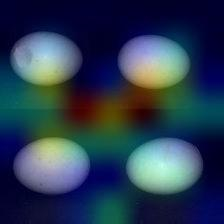

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 103.jpg
Original Image


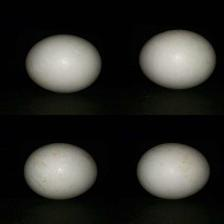

Heatmap Prediction


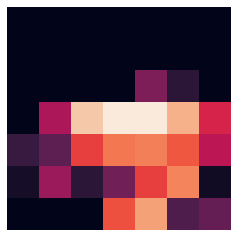

Grad-CAM


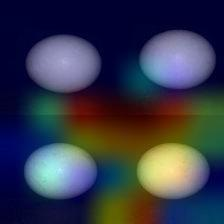

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 76.jpg
Original Image


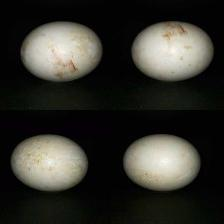

Heatmap Prediction


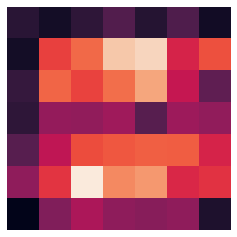

Grad-CAM


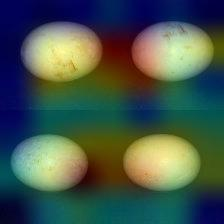

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 141.jpg
Original Image


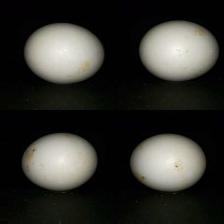

Heatmap Prediction


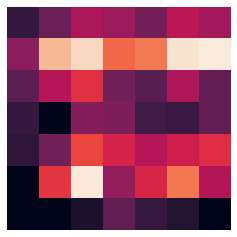

Grad-CAM


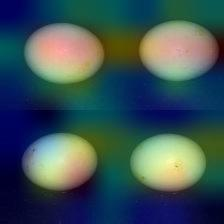

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 42.jpg
Original Image


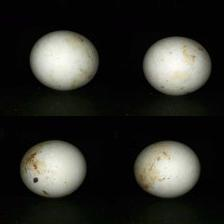

Heatmap Prediction


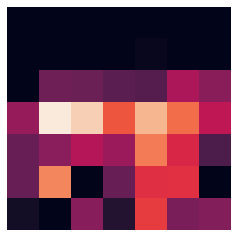

Grad-CAM


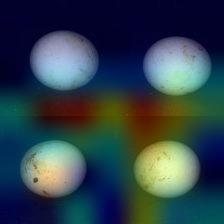

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 8.jpg
Original Image


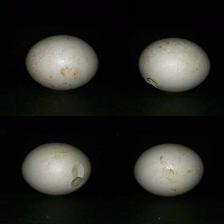

Heatmap Prediction


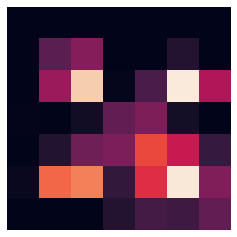

Grad-CAM


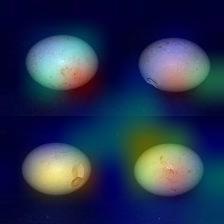

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 127.jpg
Original Image


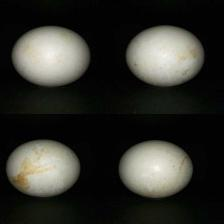

Heatmap Prediction


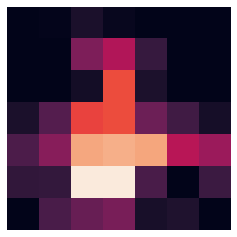

Grad-CAM


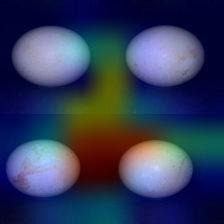

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 55.jpg
Original Image


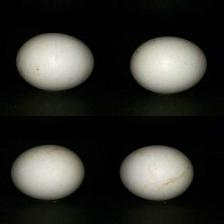

Heatmap Prediction


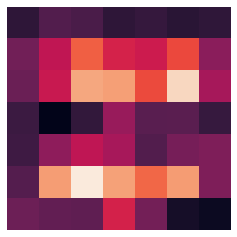

Grad-CAM


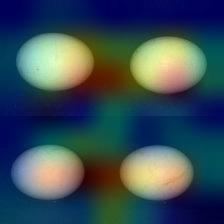

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 193.jpg
Original Image


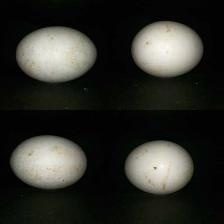

Heatmap Prediction


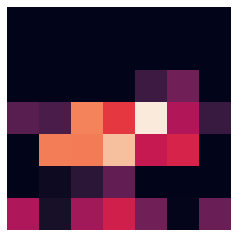

Grad-CAM


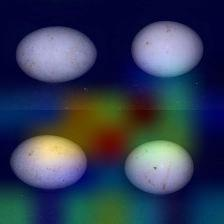

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 93.jpg
Original Image


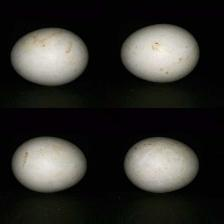

Heatmap Prediction


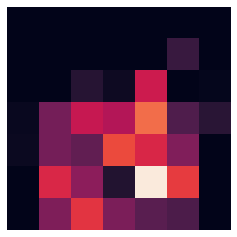

Grad-CAM


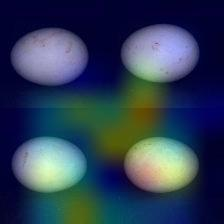

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 164.jpg
Original Image


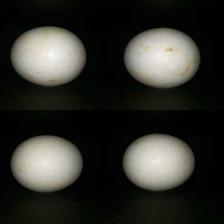

Heatmap Prediction


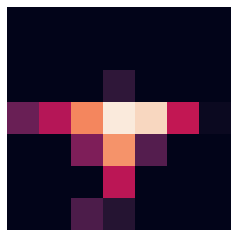

Grad-CAM


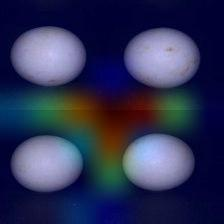

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 176.jpg
Original Image


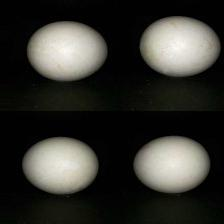

Heatmap Prediction


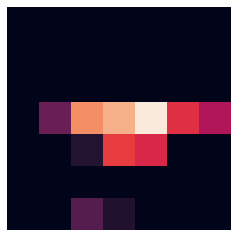

Grad-CAM


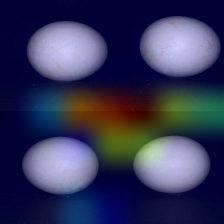

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 33.jpg
Original Image


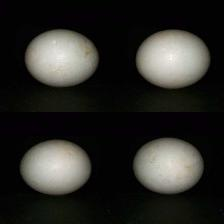

Heatmap Prediction


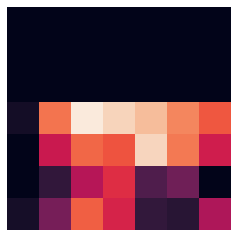

Grad-CAM


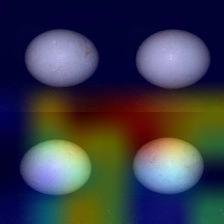

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 38.jpg
Original Image


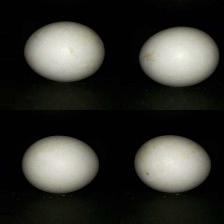

Heatmap Prediction


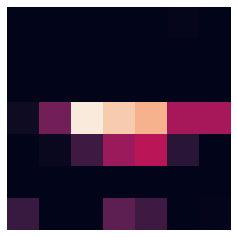

Grad-CAM


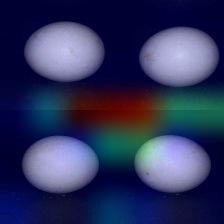

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 138.jpg
Original Image


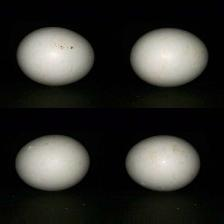

Heatmap Prediction


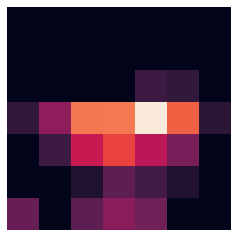

Grad-CAM


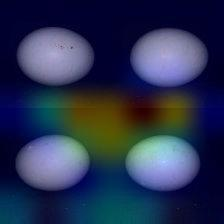

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 101.jpg
Original Image


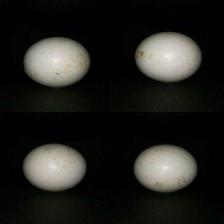

Heatmap Prediction


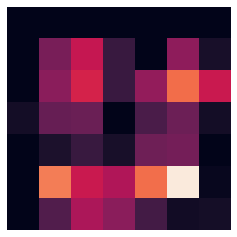

Grad-CAM


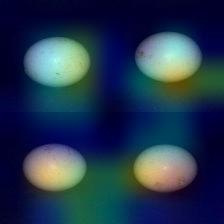

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 169.jpg
Original Image


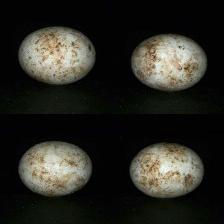

Heatmap Prediction


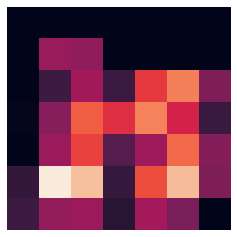

Grad-CAM


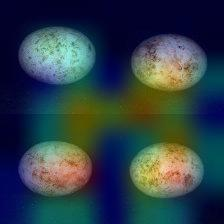

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 132.jpg
Original Image


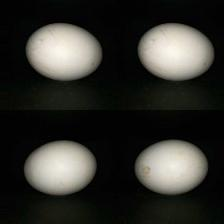

Heatmap Prediction


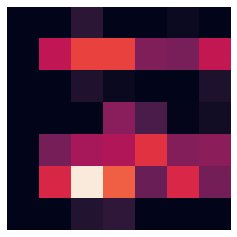

Grad-CAM


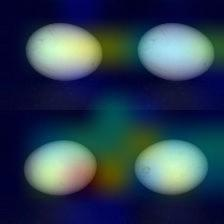

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 39.jpg
Original Image


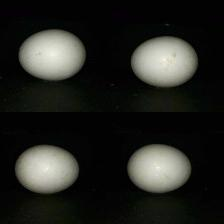

Heatmap Prediction


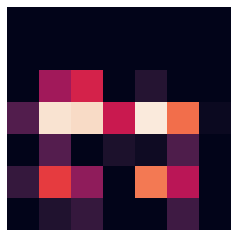

Grad-CAM


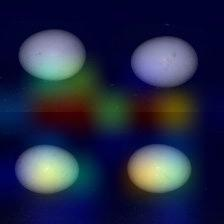

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 25.jpg
Original Image


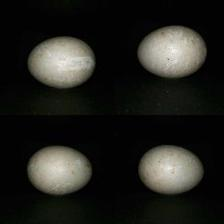

Heatmap Prediction


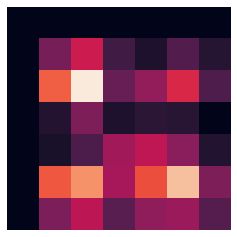

Grad-CAM


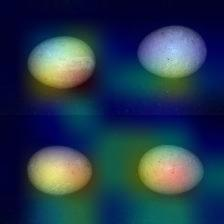

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 86.jpg
Original Image


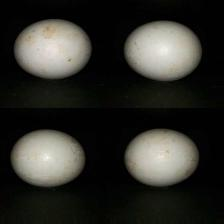

Heatmap Prediction


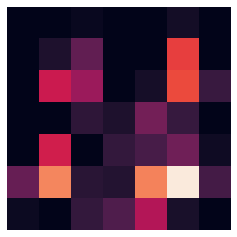

Grad-CAM


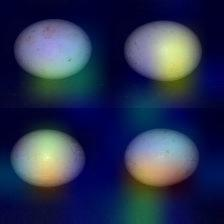

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 110.jpg
Original Image


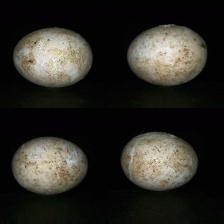

Heatmap Prediction


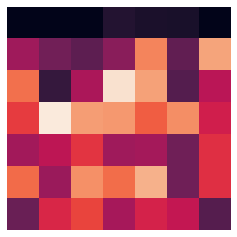

Grad-CAM


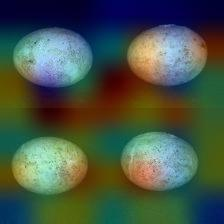

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 117.jpg
Original Image


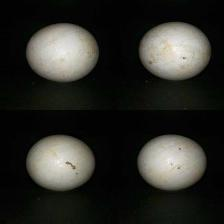

Heatmap Prediction


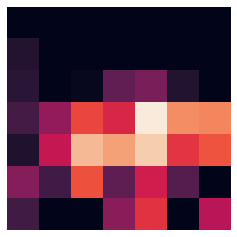

Grad-CAM


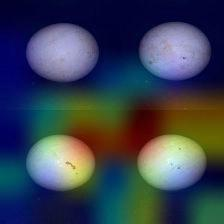

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 98.jpg
Original Image


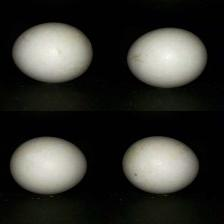

Heatmap Prediction


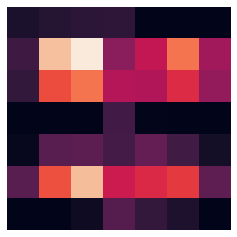

Grad-CAM


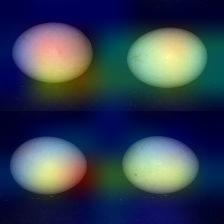

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 54.jpg
Original Image


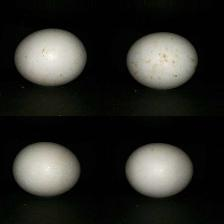

Heatmap Prediction


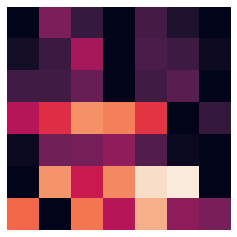

Grad-CAM


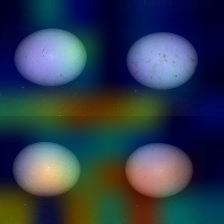

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 111.jpg
Original Image


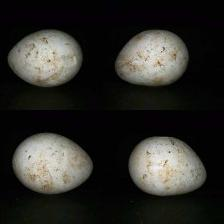

Heatmap Prediction


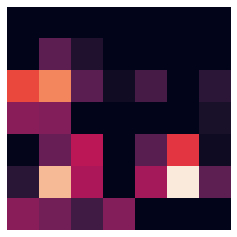

Grad-CAM


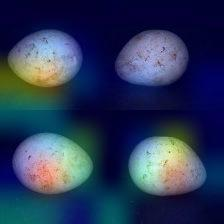

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 118.jpg
Original Image


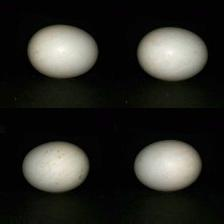

Heatmap Prediction


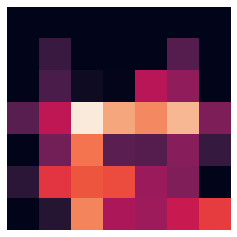

Grad-CAM


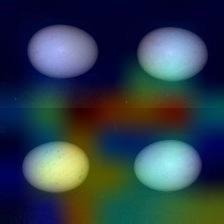

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 24.jpg
Original Image


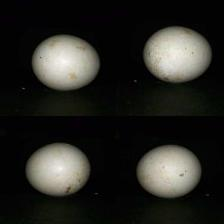

Heatmap Prediction


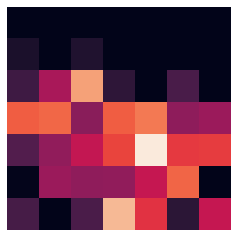

Grad-CAM


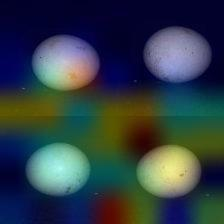

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 14.jpg
Original Image


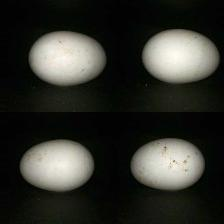

Heatmap Prediction


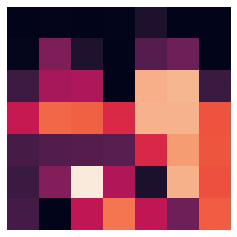

Grad-CAM


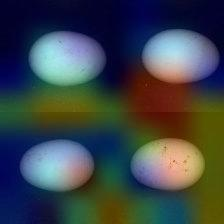

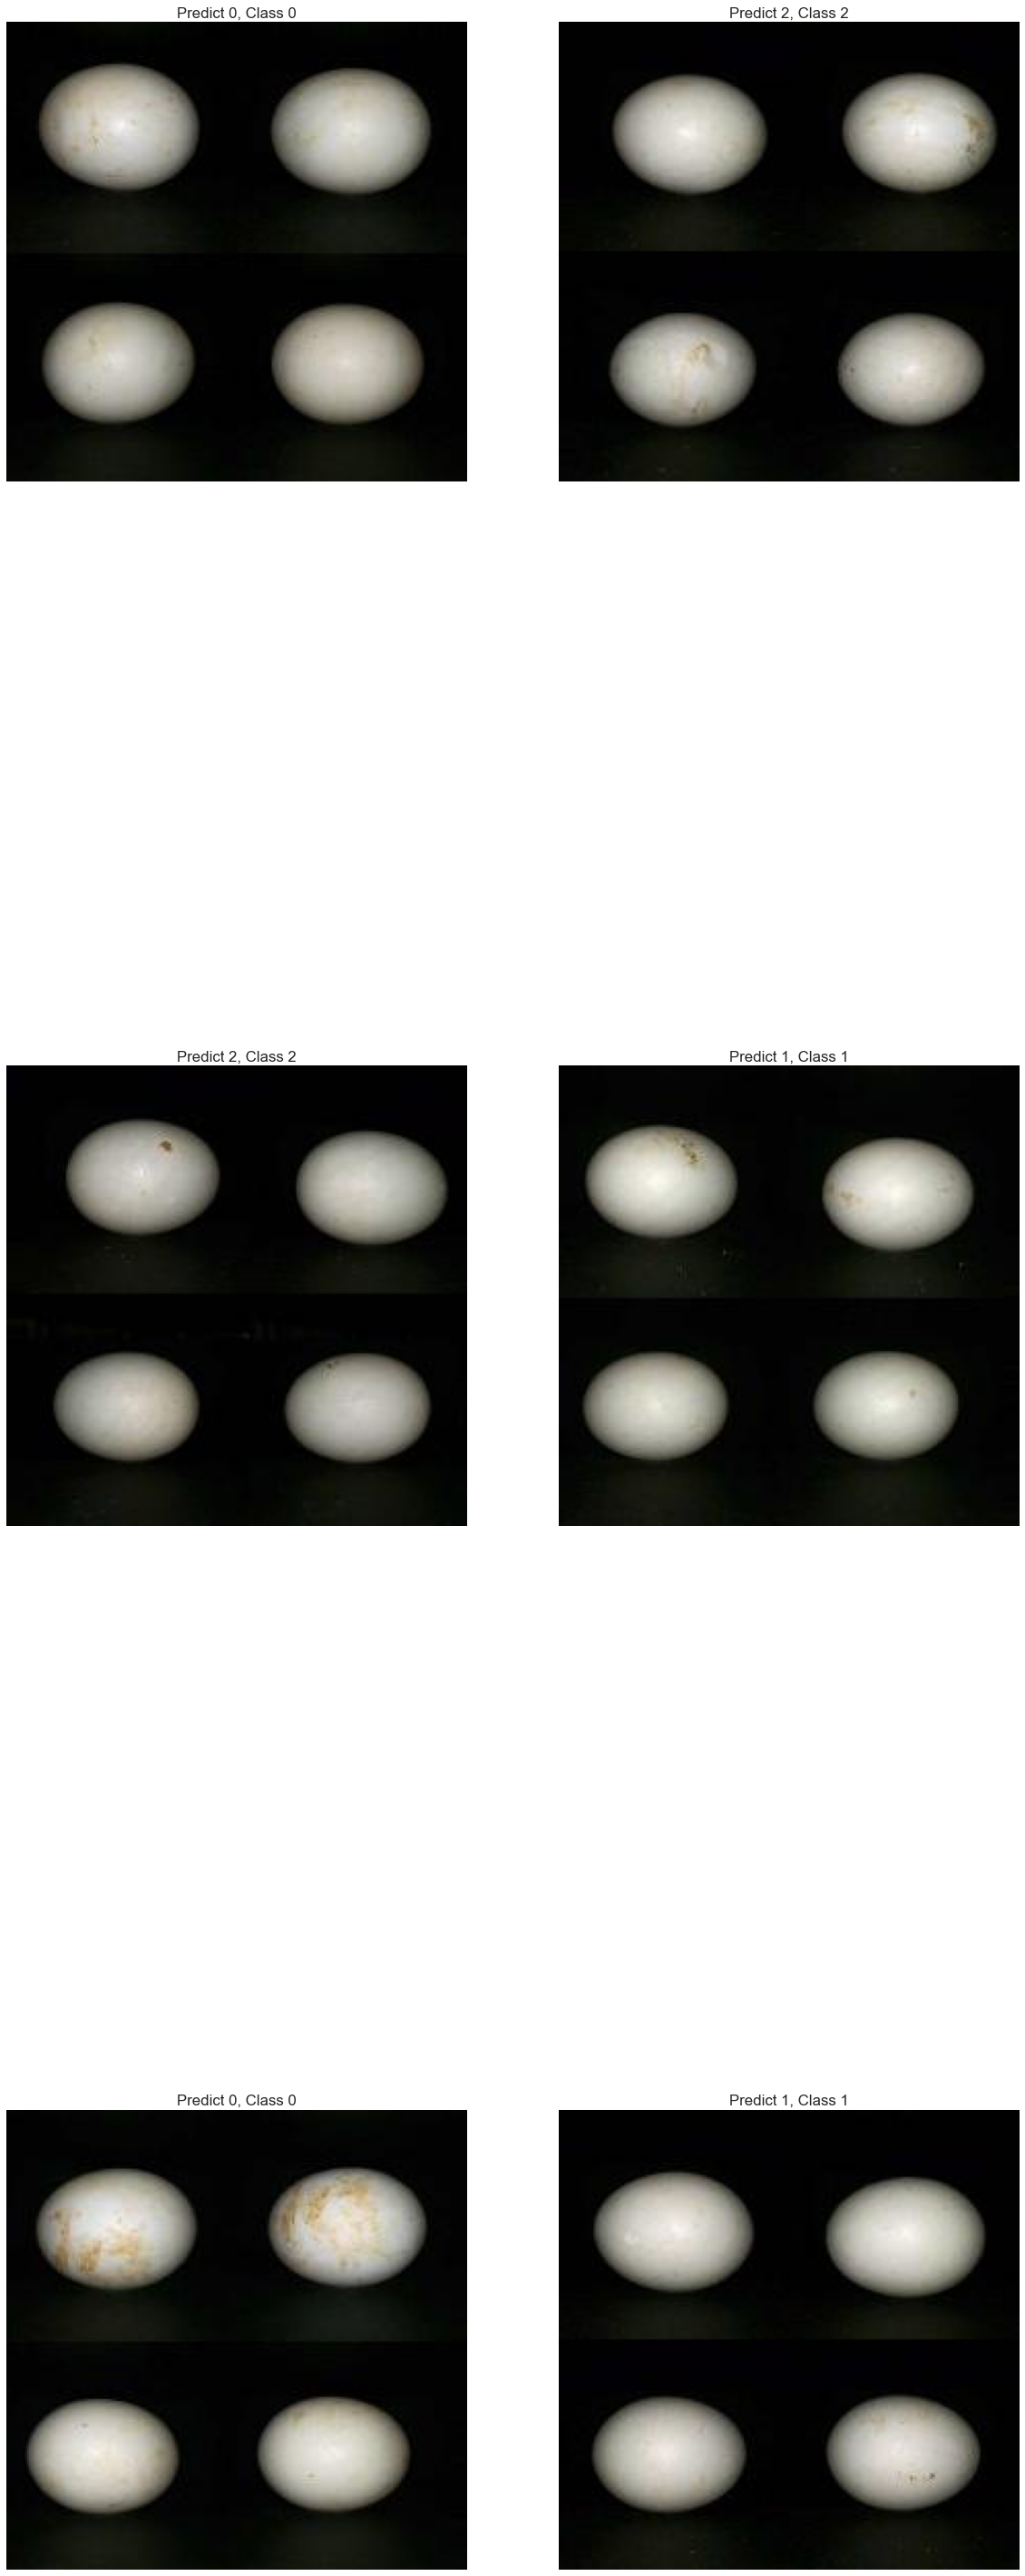

In [49]:
correct = np.where(yhat_classes2==yt)[0]

print("Found %d correct labels" % len(correct))

for x in correct:
    print("Predict {0}, Class {1}".format(str(yhat_classes2[x]),str(yt.values[x])))
    img_dir = X_test.iloc[x]['filename']
    print(img_dir)
    guraducamu(img_dir)
    
plt.figure(figsize=(20,60))
for i, correct in enumerate(correct[:6]):
    plt.subplot(3,2,i+1)
    RGB_img = cv2.cvtColor(testX2[correct], cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
    plt.title("Predict {0}, Class {1}".format(str(yhat_classes2[correct]),str(yt.values[correct])))
    plt.grid(False)
    plt.axis('off')

plt.show()

### Incorrect predictions

Found 9 incorrect labels
Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 40.jpg
Original Image


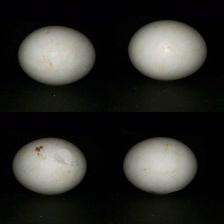

Heatmap Prediction


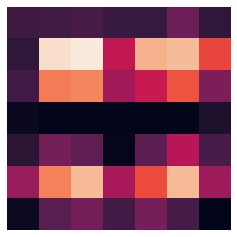

Grad-CAM


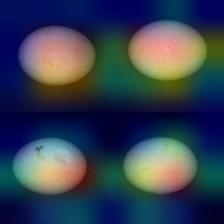

Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 191.jpg
Original Image


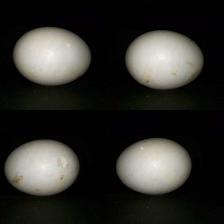

Heatmap Prediction


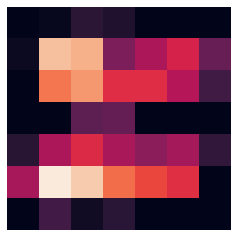

Grad-CAM


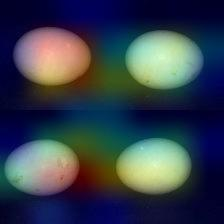

Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 62.jpg
Original Image


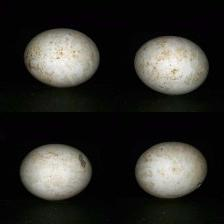

Heatmap Prediction


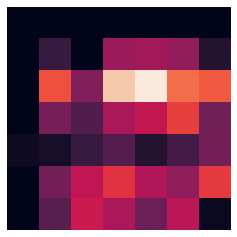

Grad-CAM


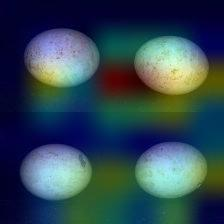

Predict 0, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 119.jpg
Original Image


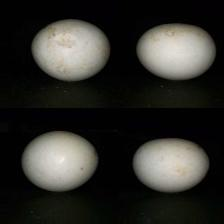

Heatmap Prediction


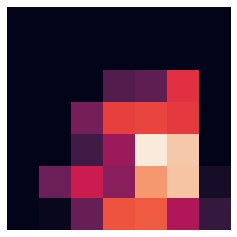

Grad-CAM


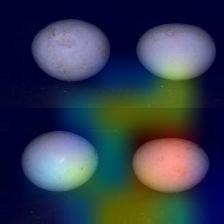

Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 123.jpg
Original Image


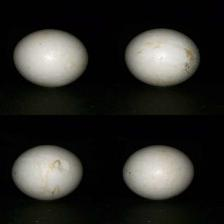

Heatmap Prediction


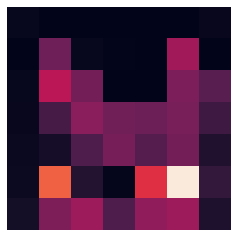

Grad-CAM


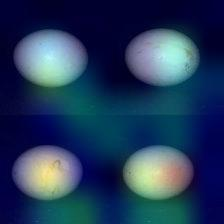

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 155.jpg
Original Image


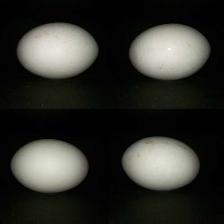

Heatmap Prediction


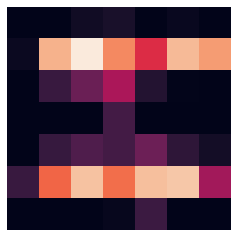

Grad-CAM


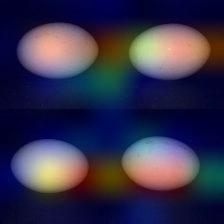

Predict 2, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 133.jpg
Original Image


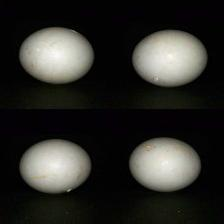

Heatmap Prediction


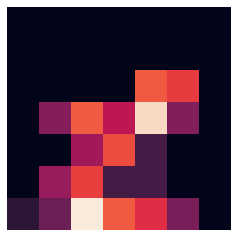

Grad-CAM


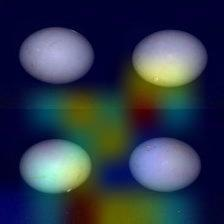

Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 49.jpg
Original Image


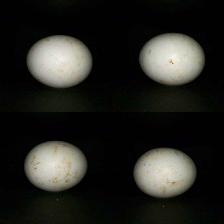

Heatmap Prediction


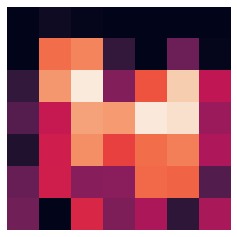

Grad-CAM


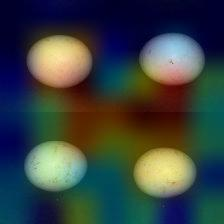

Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 71.jpg
Original Image


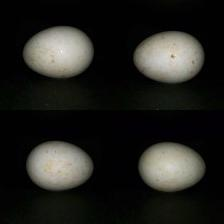

Heatmap Prediction


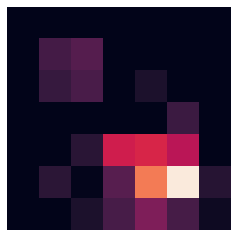

Grad-CAM


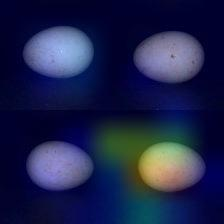

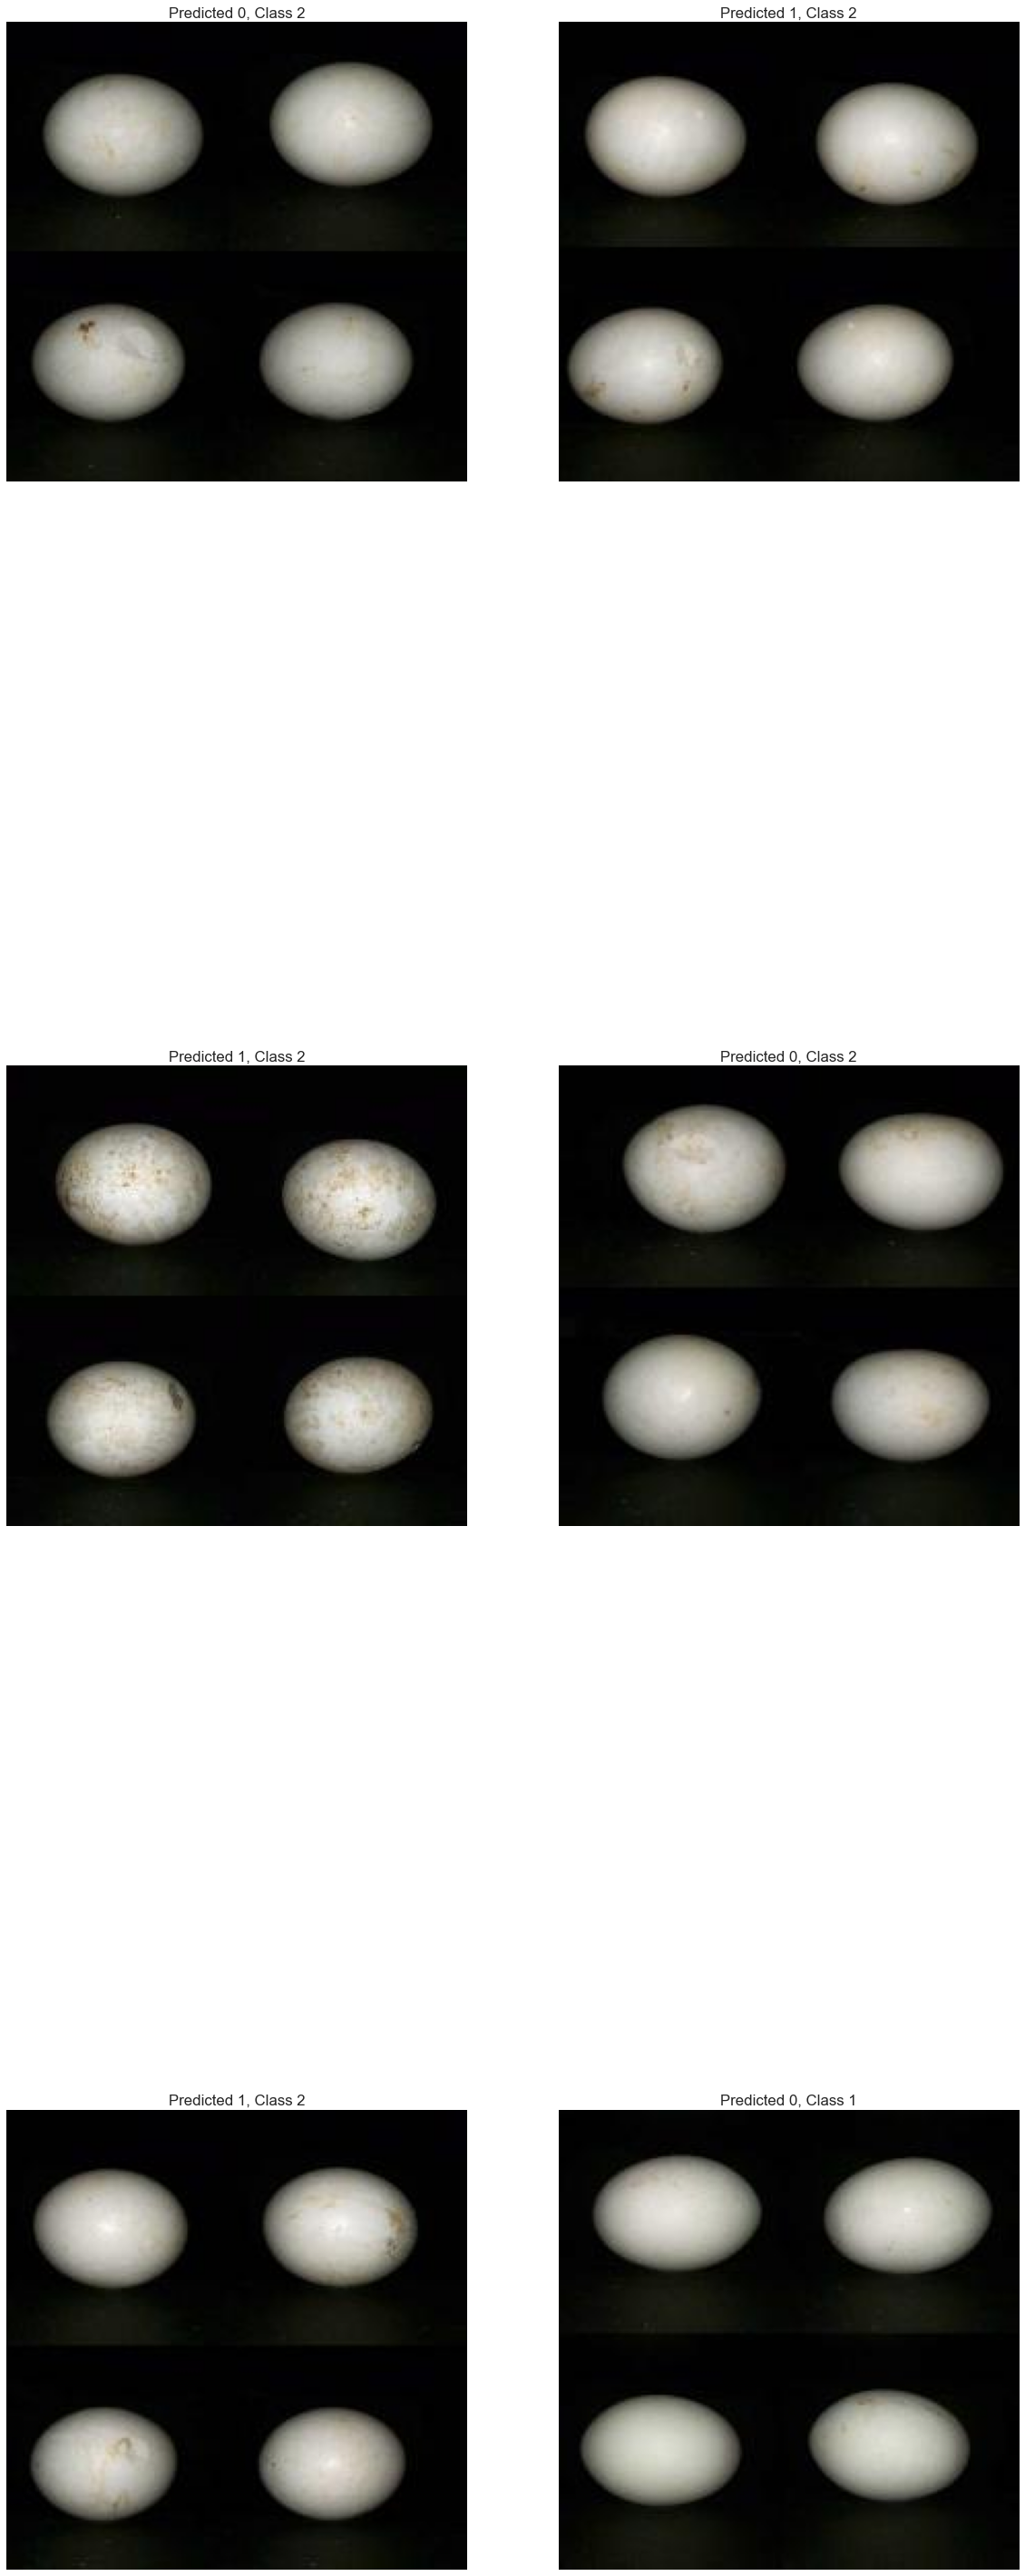

In [50]:
incorrect = np.where(yhat_classes2!=yt)[0]

print ("Found %d incorrect labels" % len(incorrect))

for x in incorrect:
    print("Predict {0}, Class {1}".format(str(yhat_classes2[x]),str(yt.values[x])))
    img_dir = X_test.iloc[x]['filename']
    print(img_dir)
    guraducamu(img_dir)

plt.figure(figsize=(20,60))
for i, incorrect in enumerate(incorrect[:6]):
    plt.subplot(3,2,i+1)
    RGB_img = cv2.cvtColor(testX2[incorrect], cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
    plt.title("Predicted {0}, Class {1}".format(str(yhat_classes2[incorrect]), str(yt.values[incorrect])))
    plt.grid(False)
    plt.axis('off')

plt.show()